# good

In [55]:
import math
import cv2

class ObjectLengthMeasurer:
    def __init__(self, image_width, image_height, horizontal_fov, vertical_fov, distance_mm):
        self.image_width = image_width
        self.image_height = image_height
        self.horizontal_fov = horizontal_fov
        self.vertical_fov = vertical_fov
        self.distance_mm = distance_mm
        self.scale_x, self.scale_y = self.calculate_scaling_factors()
        self.to_scale_x=image_width/640
        self.to_scale_y=image_height/360



    def calculate_scaling_factors(self):
        fov_x_rad = math.radians(self.horizontal_fov)
        fov_y_rad = math.radians(self.vertical_fov)
        scale_x = (2 * self.distance_mm * math.tan(fov_x_rad / 2)) / self.image_width
        scale_y = (2 * self.distance_mm * math.tan(fov_y_rad / 2)) / self.image_height
        # print(f"Scale X: {scale_x}, Scale Y: {scale_y}")  # Debugging
        return scale_x, scale_y

    def normalize_angle(self, angle):
        if angle < -45:
            angle += 90
        normalized = abs(angle)
        # print(f"Original Angle: {angle}, Normalized Angle: {normalized}")  # Debugging
        return normalized

    def compute_length(self, predicted_box_length, angle_deg):
        angle_rad = math.radians(angle_deg)
        combined_scale = math.sqrt((self.scale_x * math.cos(angle_rad)) ** 2 + 
                               (self.scale_y * math.sin(angle_rad)) ** 2)
        length_mm = predicted_box_length * combined_scale
        # print(f"Predicted Length (pixels): {predicted_box_length}, Length (mm): {length_mm}")  # Debugging
        return length_mm

    def measure_object_length(self, rect):
        angle = rect[-1]
        normalized_angle = self.normalize_angle(angle)
        predicted_box_length = max(rect[1])*8.3
    
        length_mm = self.compute_length(predicted_box_length, normalized_angle)

        if length_mm > 130 and length_mm < 250:
            print(f'angle: {angle}, normalized_angle: {normalized_angle}')
            print(f'scaling factors: {self.scale_x}, {self.scale_y}') 
            print(f"Object Length: {length_mm:.2f}" )  # Debugging


        return length_mm, normalized_angle

# Usage Example with Debugging


# # Assuming you have detected_contours from some method
# measurements = []
# for contour in detected_contours:
#     length_mm, angle = measurer.measure_object_length(contour)
#     measurements.append((length_mm, angle))
#     print(f"Object Length: {length_mm:.2f} mm at angle {angle:.2f}°")


def process_detection_by_circle(segmentation, sample,i,dataframe):
    """
    Process the prawn detection based on the enclosing circle's diameter.
    Update the filtered dataframe with the real-world size of the prawn.
    """
    poly=segmentation

    if 'right' in str(sample.tags[0]):
        height_mm =700
        focal_length = 23.64     
    else:
        height_mm=410
        focal_length=24.72
    
    image_width = 5312
    image_height = 2988
    diagonal_image_size = math.sqrt(image_width ** 2 + image_height ** 2)
    horizontal_fov = 75.2
    vertical_fov = 46
    diagonal_fov = 84.6 
   
    predicted_box_length=poly['max_length_box']
    rect=poly['rect'] 

  




    # normalized_angle=normalize_angle(angle)
    # scale_x, scale_y = calculate_scaling_factors(
    #     horizontal_fov, vertical_fov, image_width, image_height, height_mm
    # )
    
    # object_length = compute_object_length(predicted_box_length, normalized_angle, scale_x, scale_y)

    
    # if -15 <= angle <= 15 or abs(angle) > 165:  # Object is close to horizontal (aligned with the horizontal axis)
    #     print('horizontal', angle)
    #     FOV_width = 2 * height_mm * math.tan(math.radians(horizontal_fov / 2))
    #     object_length = FOV_width * predicted_box_length / image_width  # Use the width of the image (5312)

    # elif 75 <= abs(angle) <= 105:  # Object is close to vertical (aligned with the vertical axis)
    #     print('vertical', angle)
    #     FOV_height = 2 * height_mm * math.tan(math.radians(vertical_fov / 2))
    #     object_length = FOV_height * predicted_box_length / image_height  # Use the height of the image (2988)

    # else:  # Diagonal case (any orientation between horizontal and vertical)
    #     print('diagonal', angle)
    #     FOV_diagonal = 2 * height_mm * math.tan(math.radians(diagonal_fov / 2))
    #     object_length = FOV_diagonal * predicted_box_length / diagonal_image_size

    
    
    
    
    measurer = ObjectLengthMeasurer(
        image_width=5312,
        image_height=2988,
        horizontal_fov=75.2,
        vertical_fov=46.0,
        distance_mm=height_mm  # Example distance
    )

    object_length, normalized_angle = measurer.measure_object_length(rect)
    
    
    
    
    

    if object_length < 125 or object_length > 220:
        
        return poly

    image_path = sample.filepath.split('\\')[-1]

    if object_length < 165:
        best_true_length = 143
        if object_length < 143 and 'smaller than 143mm' not in sample.tags:

            print('smaller than 143mm',object_length)
            sample.tags.append('smaller than 143mm')
        if object_length < 143:      
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'yes'
        else:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'no'   

    else:
        best_true_length = 180
        if object_length < 180 and 'smaller than 180mm' not in sample.tags:

            print('smaller than 180mm',object_length)
            sample.tags.append('smaller than 180mm')

        if object_length < 180:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'yes'
        
        else:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'no'

    # for true_length in [143, 180]:
        
    

       
    #     error_percentage_hull_fov = abs(hull_length_fov - true_length) / true_length * 100
        


    #     if error_percentage_hull_fov < min_error_percentage:
    #         min_error_percentage = error_percentage_hull_fov
    #         best_true_length = true_length

    # if best_true_length == 143:
    #     height_mm = height_mm
    # else:
    #     height_mm = height_mm - 15

    measurer = ObjectLengthMeasurer(
        image_width=5312,
        image_height=2988,
        horizontal_fov=75.2,
        vertical_fov=46.0,
        distance_mm=height_mm  # Example distance
    )

    object_length, normalized_angle = measurer.measure_object_length(rect)

  
    # print(f"height_mm: {height_mm}, tag: {tag}")

    # focal_length = 24.22  # Camera focal length
    pixel_size = 0.00716844  # Pixel size in mm

    

    # fov=84.6
    # FOV_width=2*height_mm*math.tan(math.radians(fov/2))



    # # Get the diameter of the circle in pixels
    # predicted_diameter_pixels = poly['diameter']


    # predicted_skeleton_length=poly['max_length_skeleton']  

    # predicted_hull_length=poly['max_length_hull']

     
    predicted_box_length=poly['max_length_box']

    # predicted_cnt_pair=poly['max_length_cont']  
    
    center=poly['center']


    


    #add true lenght to datafram
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'true_length'] = best_true_length


    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'center'] = str(center)

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Hull_Length_pixels'] = predicted_hull_length
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Diameter_pixels'] = predicted_diameter_pixels
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Skeleton_Length_pixels'] = predicted_skeleton_length
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Box_Length_pixels'] = predicted_box_length



    # Calculate the real-world prawn size using the box
    focal_box = calculate_real_width(focal_length, height_mm, predicted_box_length, pixel_size) 


    # focal_hull = calculate_real_width(focal_length, height_mm, predicted_hull_length, pixel_size)    
    # # Calculate the real-world prawn size using the enclosing circle's diameter
    # focal_MEC = calculate_real_width(focal_length, height_mm, predicted_diameter_pixels, pixel_size)

    # focal_ske = calculate_real_width(focal_length, height_mm, predicted_skeleton_length, pixel_size)    


    # Update the filtered dataframe with the real-world size of the prawn
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Box'] = focal_box
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Hull'] = focal_hull
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_MEC'] = focal_MEC
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Skeleton'] = focal_ske



    # hull_length_fov=FOV_width*predicted_hull_length/5312
    # diameter_length_fov=FOV_width*predicted_diameter_pixels/5312
    # skeleton_length_fov=FOV_width*predicted_skeleton_length/5312

  

    # cnt_pair=FOV_width*predicted_cnt_pair/5312

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Hull_Length_fov'] = hull_length_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Diameter_fov'] = diameter_length_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Skeleton_Length_fov'] = skeleton_length_fov
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Box_Length_fov'] = object_length

    # error_percentage_cnt_pair = abs(cnt_pair - best_true_length) / best_true_length * 100


    # error_percentage_hull_fov = abs(hull_length_fov - best_true_length) / best_true_length * 100

    # error_percentage_skeleton_fov = abs(skeleton_length_fov - best_true_length) / best_true_length * 100  


    error_percentage_box_fov = abs(object_length - best_true_length) / best_true_length * 100


    # error_percentage_MEC_fov = abs(diameter_length_fov - best_true_length) / best_true_length * 100


    # MAE_hull_fov = abs(hull_length_fov - best_true_length)
    # MAE_skeleton_fov = abs(skeleton_length_fov - best_true_length)
    MAE_box_fov = abs(object_length - best_true_length)
    # MAE_MEC_fov = abs(diameter_length_fov - best_true_length)

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Hull_fov'] = MAE_hull_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Skeleton_fov'] = MAE_skeleton_fov

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_MEC_fov'] = MAE_MEC_fov

    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Box_fov'] = MAE_box_fov
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] ==image_path), 'Error_percentage_Box_fov'] = error_percentage_box_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Hull_fov'] = error_percentage_hull_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Skeleton_fov'] = error_percentage_skeleton_fov
    error_percentage_box_focal = abs(focal_box - best_true_length) / best_true_length * 100
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Box_focal'] = error_percentage_box_focal
    
    #focal mae box
    focal_MAE_box = abs(focal_box - best_true_length)
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Box_focal'] = focal_MAE_box

    #

    # # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_MEC_fov'] = error_percentage_MEC_fov

    # error_percentage_hull_focal = abs(focal_hull - best_true_length) / best_true_length * 100

    # error_percentage_skeleton_focal = abs(focal_ske - best_true_length) / best_true_length * 100


    # error_percentage_MEC_focal = abs(focal_MEC - best_true_length) / best_true_length * 100

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Hull_focal'] = error_percentage_hull_focal
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Skeleton_focal'] = error_percentage_skeleton_focal


    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_MEC_focal'] = error_percentage_MEC_focal  





    closest_detection_label = f'index:{i} ,true length: {best_true_length:.2f}mm,  MPError_hull: {error_percentage_box_fov:.2f}%, pred length: {object_length:.2f}mm, MAE: {MAE_box_fov:.2f}mm'
    # Update the filtered dataframe with the real-world size of the prawn



    if error_percentage_box_fov > 25 and f'>25% error' not in sample.tags:

        sample.tags.append(f'>25% error')

    elif error_percentage_box_fov > 15 and f'15-25% error' not in sample.tags:

        sample.tags.append(f'15-25% error')

    elif error_percentage_box_fov > 10  and f'10-15% error' not in sample.tags:

        sample.tags.append(f'10-15% error')

    elif error_percentage_box_fov < 10 and f'5-10% error' not in sample.tags:

        sample.tags.append(f'5-10% error')
    
    elif error_percentage_box_fov < 5 and f'<5% error' not in sample.tags:

        sample.tags.append(f'<5% error')


    if error_percentage_box_fov<5 and error_percentage_box_fov > best_true_length and f'very good' not in sample.tags:
        sample.tags.append('very good')





    poly.label = closest_detection_label 
    return poly
  



In [56]:
molt_right_image_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\good\640360\right\color_images"

molt_square_image_path=r"c:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\good\640360\square\color_images"

molt_prediction_right=r'C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\good\640360\right\segmentations'

molt_prediction_sqaure=r'c:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\good\640360\square\segmentations'


import pandas as pd


import fiftyone as fo
dataset = fo.Dataset("molt", overwrite=True,persistent=True)

# Load the dataset
right_image_paths = [os.path.join(molt_right_image_path, image) for image in os.listdir(molt_right_image_path) if image.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

square_image_paths = [os.path.join(molt_square_image_path, image) for image in os.listdir(molt_square_image_path) if image.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

for molt_prediction in [molt_prediction_right,molt_prediction_sqaure]:
    prediction_paths_text = [os.path.join(molt_prediction, txt) for txt in os.listdir(molt_prediction) if txt.endswith('.txt')]




    tag = molt_prediction.split('\\')[-2]

    if 'right' in molt_prediction:
        image_paths = right_image_paths
        process_images(image_paths, molt_prediction, dataset, tag)
    else:
        image_paths = square_image_paths
        process_images(image_paths, molt_prediction, dataset, tag)

# Process segmentations
dataframe = pd.DataFrame(columns=['image_path', 'index', 'pond'])

df_clean=pd.read_csv(r'C:\Users\gbo10\Videos\research\counting_research_algorithms\fifty_one\measurements\samples_index.csv')

df_seg_error=pd.read_csv(r'C:\Users\gbo10\Videos\research\counting_research_algorithms\fifty_one\measurements\molt_seg_error.csv')

df_seg_error_other=pd.read_csv(r"C:\Users\gbo10\OneDrive\research\thesis and paper\molt_seg_error.csv")


# df_seg_error=pd.concat([df_seg_error,df_seg_error_other])

for sample in dataset:

    tag = sample.tags[0]    
    # Access the polylines for each sample
    for i, segmentation in enumerate(sample["segmentations"].polylines):


        if sample.filepath.split('\\')[-1] in df_clean['sample'].values and i in df_clean.loc[df_clean['sample'] == sample.filepath.split('\\')[-1], 'index'].values:
            print(f"Skipping not prawm {sample.filepath} index {i}")
            continue
        if sample.filepath.split('\\')[-1] in df_seg_error_other['image_path'].values and i in df_seg_error_other.loc[df_seg_error_other['image_path'] == sample.filepath.split('\\')[-1], 'index'].values:
            print(f"Skipping seg error {sample.filepath} index {i}")
            continue
        if sample.filepath.split('\\')[-1] =='undistorted_GX010191_45_489.jpg' or sample.filepath.split('\\')[-1] =='undistorted_GX010191_27_215.jpg' or sample.filepath.split('\\')[-1] =='undistorted_GX010191_104_1301.jpg' or sample.filepath.split('\\')[-1]=='undistorted_GX010194_21_312.jpg' or sample.filepath.split('\\')[-1] =='undistorted_GX010191_26_199.jpg':
            print(f"Skipping image error {sample.filepath} index {i}")
            continue
        image_path = sample.filepath.split('\\')[-1]

        dataframe = dataframe._append({'image_path': image_path, 'index': i, 'pond': tag}, ignore_index=True)
        # Process and modify the segmentation
        updated_segmentation = process_detection_by_circle(segmentation, sample, i, dataframe)

        # Save the updated segmentation back into the sample
        sample["segmentations"].polylines[i] = updated_segmentation

        sample.save()

dataframe.to_csv('molt.csv')
session = fo.launch_app(dataset, port=5152)

Processing images...


100%|██████████| 66/66 [00:02<00:00, 28.99it/s]


Processing images...


100%|██████████| 56/56 [00:02<00:00, 26.55it/s]


Skipping not prawm C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\good\640360\right\color_images\undistorted_GX010191_100_1250.jpg index 0
Skipping seg error C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\good\640360\right\color_images\undistorted_GX010191_100_1250.jpg index 1
Skipping seg error C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\good\640360\right\color_images\undistorted_GX010191_100_1250.jpg index 2
angle: 84.64417266845703, normalized_angle: 84.64417266845703
scaling factors: 0.19426561011476987, 0.1903601920083234
Object Length: 142.98
smaller than 143mm 142.98050346081868
angle: 84.64417266845703, normalized_angle: 84.64417266845703
scaling factors: 0.19426561011476987, 0.1903601920083234
Object Length: 142.98
angle: 67.69379425048828, normalized_angle: 67.69379425048828
scaling factors: 0.19426561011476987, 0.1903601920083234
Object Length: 140.41
smaller than 143mm 140.4087096471602
angle: 67.693794

In [ ]:
# Calculate mutual information by 'cluster' to explore the relationship within clusters
mutual_info_by_cluster = df.groupby('cluster').apply(lambda x: mutual_info_regression(x[['min_mpe']], x['pose_eval_iou'])[0])

# Display the mutual information for each cluster
print(mutual_info_by_cluster)



cluster
0    0.031435
1    0.154360
2    0.008598
dtype: float64



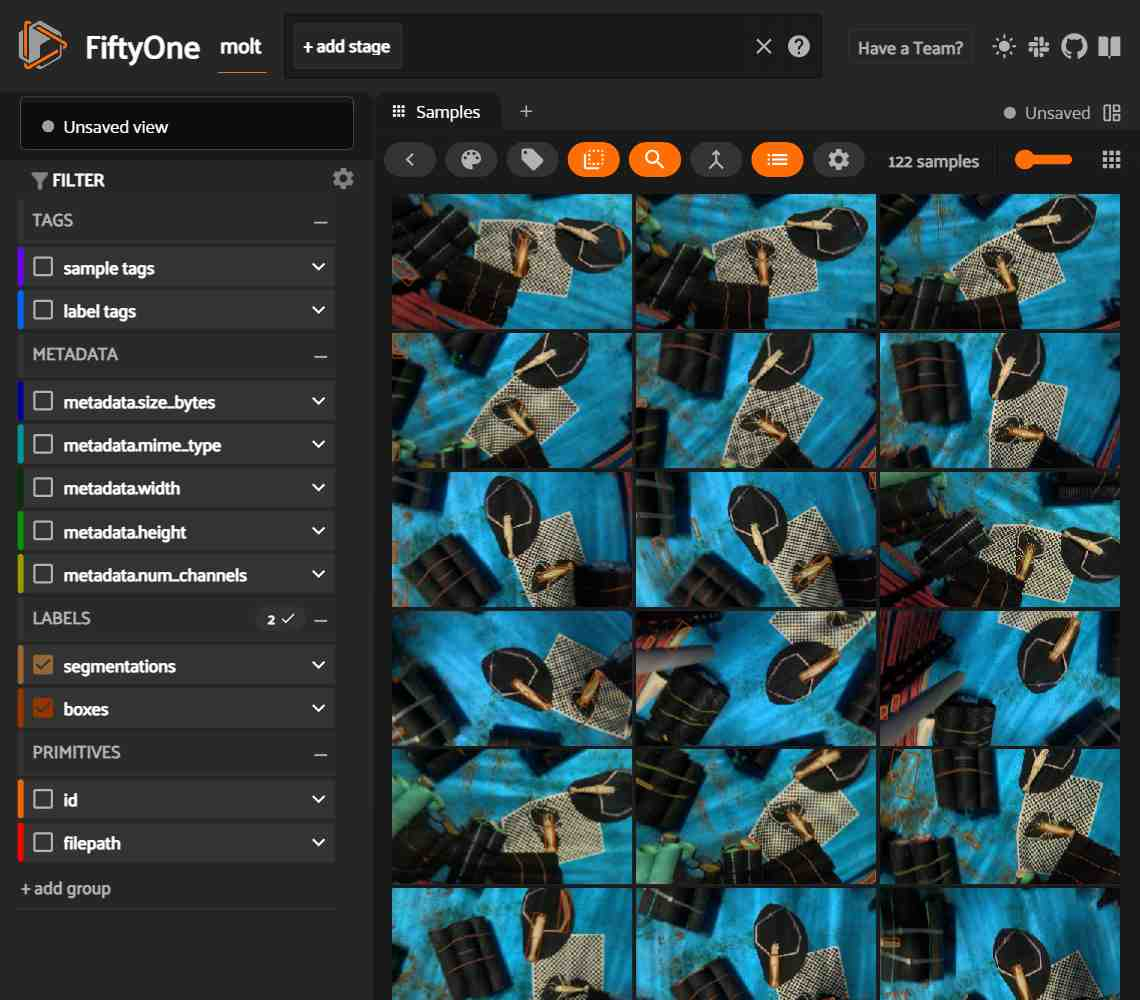

In [6]:
import fiftyone as fo

dataset=fo.load_dataset("molt")

session = fo.launch_app(dataset, port=5152)

In [ ]:

# Load the dataset


for sample in dataset:
    for i, segmentation in enumerate(sample["segmentations"].polylines):
        print(f"index: {i}, label: {segmentation.tags}")

In [81]:
print(session.view)

None


In [80]:


dataframe_seg=pd.DataFrame(columns=['image_path','index'])
from tqdm import tqdm
# 
for sample in view:
    for i, segmentation in enumerate(sample["segmentations"].polylines):
        if segmentation.label is not None:
            print(len(segmentation.tags))
            if len(segmentation.tags)>0:
                
                if segmentation.tags[0]=='under' or segmentation.tags[0]=='over':
                    print(f"under or over {sample.filepath} index {i}")
                    dataframe_seg=dataframe_seg._append({'image_path':sample.filepath.split('\\')[-1],'index':i},ignore_index=True)

            
dataframe_seg.to_csv('molt_seg_error.csv')

TypeError: 'NoneType' object is not iterable

In [1]:
import ast
import folium
from folium.plugins import MarkerCluster    
import pandas as pd
import plotly.express as px

# Read the data

# samples_index = pd.read_csv('samples_index.csv')  # Ensure this is read correctly

# # Update the 'not' column based on samples_index
# for _, sample in samples_index.iterrows():
#     df.loc[(df['image_path'] == sample['sample']) & (df['index'] == sample['index']), 'not'] = 'not'
# df.to_csv('molt_CLEAN.csv')

# # Clean the data
# df_clean = df[df['not'] != 'not']
# df_clean = df_clean.dropna()


df = pd.read_csv('molt.csv')
df_clean = df.dropna()

df_clean.loc[(df['image_path'] == 'undistorted_GX010191_43_1353.jpg') & (df['index'] == 6)] = None
#undistorted_GX010194_21_312.jpg

df_clean.loc[(df['image_path'] == 'undistorted_GX010194_21_312.jpg') & (df['index'] == 1)] = None


df_clean.dropna(inplace=True)

df_clean.loc[:, 'error_Box_fov'] = df['Box_Length_fov'] - df['true_length']
df_clean.loc[:, 'error_Box_focal'] = df['Focal_Box'] - df['true_length']
#percentage error with sign
df_clean.loc[:, 'sign_Error_percentage_Box_fov'] = (df['Box_Length_fov'] - df['true_length']) / df['true_length'] * 100


# Extract center_x and center_y from the 'center' column
df_clean['center_x'] = df_clean['center'].apply(lambda x: ast.literal_eval(x)[0])
df_clean['center_y'] = df_clean['center'].apply(lambda x: ast.literal_eval(x)[1])


# Filter the DataFrame for specific conditions
# df_positive = df_clean[(df_clean['Box_Length_fov'] > df_clean['true_length'])]
df_clean.loc[df_clean['pond']=='right','pond']=700
df_clean.loc[df_clean['pond']=='square','pond']=410

# Create a new DataFrame for visualization with necessary columns
df_visual = df_clean[['center_x', 'center_y', 'Error_percentage_Box_fov', 'image_path', 'index', 'pond', 'MAE_Box_fov','error_Box_fov','sign_Error_percentage_Box_fov']].copy()

# Ensure image paths are correct
df_visual['image_path'] = df_visual['image_path'].apply(lambda x: x.replace('\\', '/'))


# Adjust center_y coordinate to be opposite to the image
df_visual['center_y'] = 360 - df_visual['center_y']

symbols = {'right': 'circle', 'square': 'square'}
# Generate scatter plots
for error in ['Error_percentage_Box_fov', 'MAE_Box_fov','sign_Error_percentage_Box_fov']:
    for pond in [700, 410]:
        print(f"Plotting {error} for {pond}...")

        



        # Create an interactive scatter plot using plotly
        fig = px.scatter(df_visual[df_visual['pond'] == pond], 
                        symbol='pond',
                        symbol_map=symbols,
                            x='center_x', 
                            y='center_y', 
                            color=error,
                            hover_data=['image_path', 'index'],
                            color_continuous_scale='RdYlGn_r', 
                            title=f'{error} of Hull Length Prediction',)
        #
        # Customize the color bar
        fig.update_layout(coloraxis_colorbar=dict(title=error))
        fig.update_traces(marker=dict(size=10))
        #tighten the layout
        #fix legend overlapping
        fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ))    

        fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
        #save the plot as png
        fig.write_image(f'{error}_{pond}.png')
        # Show the plot
        fig.show()

C:\Users\gbo10\AppData\Local\Temp\ipykernel_35108\1391189737.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dropna(inplace=True)
C:\Users\gbo10\AppData\Local\Temp\ipykernel_35108\1391189737.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'error_Box_fov'] = df['Box_Length_fov'] - df['true_length']
C:\Users\gbo10\AppData\Local\Temp\ipykernel_35108\1391189737.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Plotting Error_percentage_Box_fov for 700...


Plotting Error_percentage_Box_fov for 410...


Plotting MAE_Box_fov for 700...


Plotting MAE_Box_fov for 410...


Plotting sign_Error_percentage_Box_fov for 700...


Plotting sign_Error_percentage_Box_fov for 410...


In [7]:
import plotly.graph_objects as go

for true_length in [143, 180]:
    df_true_length= df_clean[df_clean['true_length'] == true_length]
    fig = go.Figure()
    for pond in [700, 410]:
        df_pond = df_true_length[df_true_length['pond'] == pond]
        # fig.add_trace(go.Scatter
    # for pond in [700, 410]:
    #     df_pond = df_true_length[df_true_length['pond'] == pond]
        # fig.add_trace(go.Scatter
#scatter plot between length_fov and closest_length_min_mae_value
        fig = px.scatter(df_pond
                        ,color='pond', x='Box_Length_fov', y='true_length')
        #add title
        fig.update_layout(title=f'Length_FOV_box vs. closest_length_min_mae_value')
        # fig.add_trace(go.Scatter(x=[120, 200], y=[120, 200], mode='lines', name='line'))

        #save the plot to png
        fig.write_image(f'full body_Length_FOV_box vs. closest_length_min_mae_value.png')
        #add a trendline

        #add line


        fig.show()
#

In [11]:
for pond in [700, 410]:
  print(len (df_clean[df_clean['pond'] == pond]['image_path'].unique()))

43
29


In [14]:
df_clean['true_length'].value_counts()

true_length
143.0    43
180.0    42
Name: count, dtype: int64

In [63]:
error_data=pd.DataFrame(columns=['true_length','pond','mean_error','mean_error_percentage','mean_mae','mean_prediction_length','std_prediction_length'])


for true_length in [143, 180]:
    for pond in [700, 410]:
       #mean errors 
        # print(f"Mean Error for {true_length}mm in pond {pond}:")
        # print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['error_Box_fov'].mean())
        # #mean error percentage
        print(f"Mean fov Error Percentage for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Error_percentage_Box_fov'].mean())
        #mean mae
        print(f"Mean fov MAE for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['MAE_Box_fov'].mean())

        #mean prediction length and std
        print(f"Mean fov Prediction Length for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Box_Length_fov'].mean())
        print(f"Std fov Prediction Length for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Box_Length_fov'].std())



        #mean error percentage focal
        print(f"Mean focal Error Percentage for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Error_percentage_Box_focal'].mean())

        #mean mae focal
        print(f"Mean focal MAE for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['MAE_Box_focal'].mean())

        #mean focal length and std
        print(f"Mean Focal Length for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Focal_Box'].mean())
        print(f"Std Focal Length for {true_length}mm in pond {pond}:")
        print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Focal_Box'].std())

        # #mean error focal
        # print(f"Mean Error for {true_length}mm in pond {pond}:")
        # print(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['error_Box_focal'].mean())

       
        #count of prawns
        print(f"Count of {true_length}mm in pond {pond}:")
        print(len(df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]))

        #add all to datafraem including focal   
        error_data=error_data._append({'true_length':true_length,'pond':pond,'mean_error':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['error_Box_fov'].mean(),'mean_error_percentage':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Error_percentage_Box_fov'].mean(),'mean_mae':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['MAE_Box_fov'].mean(),'mean_prediction_length':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Box_Length_fov'].mean(),'std_prediction_length':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Box_Length_fov'].std(),'mean_error_focal':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['error_Box_focal'].mean(),'mean_error_percentage_focal':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Error_percentage_Box_focal'].mean(),'mean_mae_focal':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['MAE_Box_focal'].mean(),'mean_prediction_length_focal':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Focal_Box'].mean(),'std_prediction_length_focal':df_clean[(df_clean['true_length'] == true_length) & (df_clean['pond'] == pond)]['Focal_Box'].std()},ignore_index=True)

error_data

        

Mean fov Error Percentage for 143mm in pond 700:
4.899529730238061
Mean fov MAE for 143mm in pond 700:
7.006327514240428
Mean fov Prediction Length for 143mm in pond 700:
146.61375109064838
Std fov Prediction Length for 143mm in pond 700:
8.14282327866182
Mean focal Error Percentage for 143mm in pond 700:
8.436450554594506
Mean focal MAE for 143mm in pond 700:
12.064124293070146
Mean Focal Length for 143mm in pond 700:
154.93912140851393
Std Focal Length for 143mm in pond 700:
8.236981827344096
Count of 143mm in pond 700:
31
Mean fov Error Percentage for 143mm in pond 410:
5.452974386569332
Mean fov MAE for 143mm in pond 410:
7.797753372794146
Mean fov Prediction Length for 143mm in pond 410:
150.79775337279415
Std fov Prediction Length for 143mm in pond 410:
4.535975774416189
Mean focal Error Percentage for 143mm in pond 410:
6.040163616376347
Mean focal MAE for 143mm in pond 410:
8.637433971418176
Mean Focal Length for 143mm in pond 410:
151.63743397141818
Std Focal Length for 143mm 

C:\Users\gbo10\AppData\Local\Temp\ipykernel_51412\940956615.py:48: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,true_length,pond,mean_error,mean_error_percentage,mean_mae,mean_prediction_length,std_prediction_length,mean_error_focal,mean_error_percentage_focal,mean_mae_focal,mean_prediction_length_focal,std_prediction_length_focal
0,143.0,700.0,3.613751,4.899530,7.006328,146.613751,8.142823,11.939121,8.436451,12.064124,154.939121,8.236982
1,143.0,410.0,7.797753,5.452974,7.797753,150.797753,4.535976,8.637434,6.040164,8.637434,151.637434,4.272303
2,180.0,700.0,7.765411,5.781450,10.406610,187.765411,9.335248,18.647140,10.359522,18.647140,198.647140,9.852803
3,180.0,410.0,11.676792,6.487107,11.676792,191.676792,6.688534,13.960814,7.756008,13.960814,193.960814,6.944531


In [64]:
#remove mean_error and mean_error_focal
error_data.drop(['mean_error','mean_error_focal'],axis=1,inplace=True)  

In [67]:
#without index
error_data.to_csv('error_data.csv',index=False)

In [59]:
for error in ['Error_percentage_Box_fov', 'MAE_Box_fov']:

    for true_length in [143, 180]:
        # Create a box plot using plotly
        fig = px.box(df_clean[df_clean['true_length'] == true_length],
                        x='pond', 
                        y=error, 
                        points="all",  # Show all points
                        hover_data=['image_path', 'index'],  # Include hover data
                        title=f'Box plot of {error} for {true_length}mm',)
        #Save the plot to png
        fig.write_image(f'{error}_{true_length}.png')
        fig.show()
    # Create a box plot using plotly
        

In [70]:
for error in ['Error_percentage_Box_fov', 'MAE_Box_fov']:

    for true_length in [143, 180]:
        # Create a violin plot using plotly 
        fig = px.violin(df_clean[df_clean['true_length'] == true_length],
                        x='pond', 
                        y=error, 
                        box=True,  # Include box plot
                        points="all",  # Show all points
                        hover_data=['image_path', 'index'],  # Include hover data
                        title=f'Violin plot of {error} for {true_length}mm',)
        #Save the plot to png
        fig.write_image(f'violin {error}_{true_length}.png')
        fig.show()

In [62]:
import pandas as pd

# Data dictionary
data = {
    "Pond": ["700", "700", "410", "410", "700", "700", "410", "410"],
    "Length (mm)": [143, 180, 143, 180, 143, 180, 143, 180],
    "Error Percentage (FOV)": [4.899529730238061, 5.781450236029387, 5.452974386569332, 6.48710656141262, 
                                8.436450554594506, 10.359522295616694, 6.040163616376347, 7.756007555380738],
    "MAE (FOV)": [7.006327514240428, 10.406610424852895, 7.797753372794146, 11.676791810542717, 
                  12.064124293070146, 18.64714013211005, 8.637433971418176, 13.96081359968533],
    "Prediction Length (FOV)": [146.61375109064838, 187.76541051917866, 150.79775337279415, 191.67679181054274, 
                                154.93912140851393, 198.64714013211002, 151.63743397141818, 193.96081359968534],
    "Std Prediction Length (FOV)": [8.14282327866182, 9.335248092347655, 4.535975774416189, 6.688533642033929, 
                                    8.236981827344096, 9.852803262083826, 4.272302709449057, 6.944530514583651],
    "Count": [31, 27, 13, 15, 31, 27, 13, 15]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display as a table
df


,Pond,Length (mm),Error Percentage (FOV),MAE (FOV),Prediction Length (FOV),Std Prediction Length (FOV),Count
0,700,143,4.899530,7.006328,146.613751,8.142823,31
1,700,180,5.781450,10.406610,187.765411,9.335248,27
2,410,143,5.452974,7.797753,150.797753,4.535976,13
3,410,180,6.487107,11.676792,191.676792,6.688534,15
4,700,143,8.436451,12.064124,154.939121,8.236982,31
5,700,180,10.359522,18.647140,198.647140,9.852803,27
6,410,143,6.040164,8.637434,151.637434,4.272303,13
7,410,180,7.756008,13.960814,193.960814,6.944531,15


In [18]:
len(df['image_path'].unique())

100

In [66]:
dataset=fo.load_dataset('molt')
session=fo.launch_app(dataset,port=5152)

In [ ]:
mae=df_clean['MAE_Hull_fov'].mean()

In [62]:
len(df_positive)

165

In [51]:
pd.DataFrame(samples_index).to_csv('samples_index.csv')

In [40]:
df['pond'].unique()

array(['square'], dtype=object)

In [ ]:
df

In [90]:
#session save view
session = fo.launch_app(dataset,port=5154)


Could not connect session, trying again in 10 seconds



In [33]:
#print workspace

print (session.view)

Dataset:     molt
View name:   molt
Media type:  image
Num samples: 122
Sample fields:
    id:                           fiftyone.core.fields.ObjectIdField
    filepath:                     fiftyone.core.fields.StringField
    tags:                         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    segmentations:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Polylines)
    hulls:                        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Polylines)
    skeletons_no_smooth:          fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Polylines)
    skeletons_straight_no_smooth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Polylines)
    boxes:                        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Polylines)
    masks:        

In [34]:


# Export the view to CSV
export_path = "saved_view_data.csv"
session.view.export(
    export_path,
    dataset_type=fo.types.CSVDataset,
    fields=["id", "filepath", "tags", "metadata"]  # Adjust fields as needed
)


 100% |█████████████████| 122/122 [510.6ms elapsed, 0s remaining, 238.9 samples/s]      


In [6]:
from tqdm import tqdm

image_paths=r'C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\unditorted'

output_path=r'C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\unditorted\undistorted_resized'

image_paths = [os.path.join(image_paths, image) for image in os.listdir(image_paths) if image.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

for image_path in tqdm(image_paths):
    #resize the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (640, 640))
    cv2.imwrite(os.path.join(output_path, os.path.basename(image_path)), img)

100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


In [7]:
import cv2
import numpy as np
from tqdm import tqdm
import os


molt_image_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\molt\all molt\undistorted"


output_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\molt\all molt\undistorted\first_process"


os.makedirs(output_path, exist_ok=True)

# do the code below on entire folder
image_paths = [os.path.join(molt_image_path, image) for image in os.listdir(molt_image_path) if image.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]

for image_path in tqdm(image_paths):

# Load the image
    image = cv2.imread(image_path)

    # Step 1: Convert to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    white_mask=cv2.inRange(image, (60, 60, 60), (255, 255, 255))

    # cv2.imwrite("white_mask.png", white_mask)    



    very_white_mask = cv2.inRange(image, (150, 150, 150), (255, 255, 255))


    image[very_white_mask == 255] = [0, 0, 0]  # Change white to gray


    # cv2.imwrite("very_white_mask.png", image)


    gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

    # Save the result
    # cv2.imwrite("binary_image.png", binary)


    # cv2.imwrite("gray.png", gray)


    # white_mask_from_binary = cv2.bitwise_not(binary)  # Invert the binary mask to get white areas

    # cv2.imwrite("white_mask_from_binary.png", white_mask_from_binary)


    gray_color = np.array([52, 66, 79])  # RGB value for gray
    # image[white_mask == 255] = gray_color

    # Step 2: Threshold the image to isolate black areas (under prawns)
    # Adjust threshold values depending on how black the segments are
    _, black_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Isolating black areas (threshold of 50)


    # cv2.imwrite("black_mask.png", black_mask)

    # Step 3: Create a bluish image to apply to black areas
    bluish_image = image.copy()
    bluish_image[:] = [212, 156, 31]  # BGR for blue


    #white mask on the black segments
    # white_on_black = cv2.bitwise_and(white_mask_from_binary, black_mask)  # Isolate white areas on the black segments

    # cv2.imwrite("white_on_black.png", white_on_black)


    # # Step 6: Convert white to gray in those areas
    # # gray_color = np.array([128, 128, 128])  # RGB value for gray
    # image[white_on_black==0] = gray_color  # Change white on black to gray


    image[white_mask == 255] = gray_color

    # Step 4: Apply bluish color to the black regions
    image[black_mask == 255] = bluish_image[black_mask == 255]





    # Step 5: Isolate white areas (likely prawns) within the black segments
    # Detect white pixels in the original image (on the black segments only)
    # white_on_black = cv2.bitwise_and(white_mask, black_mask)  # Isolate white areas on the black segments

    # Step 6: Convert white to gray in those areas
    # gray_color = np.array([128, 128, 128])  # RGB value for gray
    # image[white_on_black == 255] = gray_color  # Change white on black to gray

    # Step 7: Display the final image
    # cv2.imshow("Result", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Save the result


    #resize the image
    resized_image = cv2.resize(image, (640, 360))



    cv2.imwrite(os.path.join(output_path, os.path.basename(image_path)), resized_image)


100%|██████████| 191/191 [03:31<00:00,  1.11s/it]


In [8]:



image = cv2.imread(r"C:\Users\gbo10\OneDrive\measurement_paper_images\molt\image processed\vlcsnap-2024-09-21-02h23m31s263.png")

    # Step 1: Convert to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


white_mask=cv2.inRange(image, (60, 60, 60), (255, 255, 255))

# cv2.imwrite("white_mask.png", white_mask)    



very_white_mask = cv2.inRange(image, (150, 150, 150), (255, 255, 255))


image[very_white_mask == 255] = [0, 0, 0]  # Change white to gray


# cv2.imwrite("very_white_mask.png", image)


gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

# Save the result
# cv2.imwrite("binary_image.png", binary)


# cv2.imwrite("gray.png", gray)


# white_mask_from_binary = cv2.bitwise_not(binary)  # Invert the binary mask to get white areas

# cv2.imwrite("white_mask_from_binary.png", white_mask_from_binary)


gray_color = np.array([132, 129, 122])  # RGB value for gray
# image[white_mask == 255] = gray_color

# Step 2: Threshold the image to isolate black areas (under prawns)
# Adjust threshold values depending on how black the segments are
_, black_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Isolating black areas (threshold of 50)


# cv2.imwrite("black_mask.png", black_mask)

# Step 3: Create a bluish image to apply to black areas
bluish_image = image.copy()
bluish_image[:] = [212, 156, 31]  # BGR for blue


#white mask on the black segments
# white_on_black = cv2.bitwise_and(white_mask_from_binary, black_mask)  # Isolate white areas on the black segments

# cv2.imwrite("white_on_black.png", white_on_black)


# # Step 6: Convert white to gray in those areas
# # gray_color = np.array([128, 128, 128])  # RGB value for gray
# image[white_on_black==0] = gray_color  # Change white on black to gray


image[white_mask == 255] = gray_color

# Step 4: Apply bluish color to the black regions
image[black_mask == 255] = bluish_image[black_mask == 255]





# Step 5: Isolate white areas (likely prawns) within the black segments
# Detect white pixels in the original image (on the black segments only)
# white_on_black = cv2.bitwise_and(white_mask, black_mask)  # Isolate white areas on the black segments

# Step 6: Convert white to gray in those areas
# gray_color = np.array([128, 128, 128])  # RGB value for gray
# image[white_on_black == 255] = gray_color  # Change white on black to gray

# Step 7: Display the final image
# cv2.imshow("Result", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Save the result

#resize the image
cv2.imwrite(r"vlcsnap-2024-09-21-02h23m31s263.png", image)

True

In [9]:
import cv2
import numpy as np

# Load a binary image

image = cv2.imread(r'C:\Users\gbo10\Videos\research\counting_research_algorithms\fifty_one\measurements\vlcsnap-2024-09-21-02h23m31s263.png')

# # Convert to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# #save the gray image
# cv2.imwrite("gray_image.png", gray)
gray_color = np.array([122, 129, 132])  # RGB value for gray

lower_bound = gray_color -100 # Allow a small tolerance
upper_bound = gray_color + 100

# Create a mask where the pixels are within the range of the gray color
mask = cv2.inRange(image, lower_bound, upper_bound)

# Invert the mask to get the pixels that are NOT the gray color

cv2.imwrite("mask.png", mask)

# # Make the non-gray pixels black by applying the inverted mask
# result = image.copy()
# # result[mask_inv == 255] = [0, 0, 0] 


#thershold the image using gray_color = np.array([132, 129, 122])  # RGB value for gray


# cv2.imwrite("result.png", result)

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Found {len(contours)} contours")

conutres1=[]

i=0
# Iterate through contours
for contour in contours:
    # Calculate area and perimeter (arc length)
    area = cv2.contourArea(contour)
    # perimeter = cv2.arcLength(contour, True)
   
    if area > 90000:
        

        conutres1.append(contour)

        print(f"Contour {i}: Area: {area:.2f}")
        cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
        i+=1


#     #Draw the contour

#what is not in the contures1 paint in azure   
    
   
# # Save the output image
cv2.imwrite('ellipses_output.png', image)




# Find contours
# contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# # Draw contours on the original image
# output_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR for color drawing
# cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)  # Draw all contours in green

# Save the output image
# cv2.imwrite('contours_output.png', output_image)


Found 1824 contours
Contour 0: Area: 579477.00
Contour 1: Area: 544803.50


True

In [10]:

import cv2
import numpy as np

# Load the image
image = cv2.imread(r"C:\Users\gbo10\OneDrive\measurement_paper_images\molt\all molt\undistorted\first_process\right\azure\undistorted_GX010191_37_392.jpg")

# Define the color to paint the background (Azure color in BGR format)
azure_color = [212, 156, 31]  # Azure in BGR (Blue, Green, Red)

# Define gray color and tolerance
gray_color = np.array([52, 66, 79])  # RGB value for gray
lower_bound = gray_color - 50
upper_bound = gray_color + 50


# Create a mask for the gray color
mask = cv2.inRange(image, lower_bound, upper_bound)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area and create a new mask for the contours
contours_mask = np.zeros_like(mask)  # A black mask of the same size as the original image

# Iterate through contours and draw only the ones with sufficient area
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 500: 
        print (area)
        # Draw the contours on the black mask
        cv2.drawContours(contours_mask, [contour], -1, 255, thickness=cv2.FILLED)  # Fill the contours in white

# Invert the contours mask (make contours black and the rest white)
contours_mask_inv = cv2.bitwise_not(contours_mask)

# Create a background image filled with the azure color
azure_background = np.full_like(image, azure_color, dtype=np.uint8)

# Mask out the contour areas and paint the rest azure
result = cv2.bitwise_and(image, image, mask=contours_mask)  # Keep the original image inside the contours
azure_areas = cv2.bitwise_and(azure_background, azure_background, mask=contours_mask_inv)  # Paint everything else azure

# Combine the original image (inside contours) with the azure background (outside contours)
final_result = cv2.add(result, azure_areas)

# Save and display the final result
cv2.imwrite("result_azure_background.png", final_result)



589.5
32496.5
12145.0
3556.5
1674.5
638.0


True

In [11]:
    
import cv2
import numpy as np
import os
from tqdm import tqdm

molt_image_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\molt\all molt\undistorted\first_process\square"


output_path = r"C:\Users\gbo10\OneDrive\measurement_paper_images\molt\all molt\undistorted\first_process\square\azure"

os.makedirs(output_path, exist_ok=True) 

image_paths = [os.path.join(molt_image_path, image) for image in os.listdir(molt_image_path) if image.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]


for image_path in tqdm(image_paths):

    # Load the image
    image = cv2.imread(image_path)
    azure_color = [212, 156, 31]  # Azure in BGR (Blue, Green, Red)

    # Define gray color and tolerance
    gray_color = np.array([52, 66, 79])  # RGB value for gray
    lower_bound = gray_color - 50
    upper_bound = gray_color + 50

    # Create a mask for the gray color
    mask = cv2.inRange(image, lower_bound, upper_bound)

    cv2.imwrite("mask.png", mask)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and create a new mask for the contours
    contours_mask = np.zeros_like(mask)  # A black mask of the same size as the original image

    # Iterate through contours and draw only the ones with sufficient area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >800:  
            
     
            # Filter by area
            # Draw the contours on the black mask
            cv2.drawContours(contours_mask, [contour], -1, 255, thickness=cv2.FILLED)  # Fill the contours in white

    # Invert the contours mask (make contours black and the rest white)
    contours_mask_inv = cv2.bitwise_not(contours_mask)

    # Create a background image filled with the azure color
    azure_background = np.full_like(image, azure_color, dtype=np.uint8)

    # Mask out the contour areas and paint the rest azure
    result = cv2.bitwise_and(image, image, mask=contours_mask)  # Keep the original image inside the contours
    azure_areas = cv2.bitwise_and(azure_background, azure_background, mask=contours_mask_inv)  # Paint everything else azure

    # Combine the original image (inside contours) with the azure background (outside contours)
    final_result = cv2.add(result, azure_areas)

    #Save the result
    cv2.imwrite(os.path.join(output_path, os.path.basename(image_path)), final_result)



  0%|          | 0/93 [00:00<?, ?it/s]

100%|██████████| 93/93 [00:02<00:00, 41.29it/s]


In [ ]:
import math
import cv2

class ObjectLengthMeasurer:
    def __init__(self, image_width, image_height, horizontal_fov, vertical_fov, distance_mm):
        self.image_width = image_width
        self.image_height = image_height
        self.horizontal_fov = horizontal_fov
        self.vertical_fov = vertical_fov
        self.distance_mm = distance_mm
        self.scale_x, self.scale_y = self.calculate_scaling_factors()
        self.to_scale_x=image_width/640
        self.to_scale_y=image_height/360



    def calculate_scaling_factors(self):
        fov_x_rad = math.radians(self.horizontal_fov)
        fov_y_rad = math.radians(self.vertical_fov)
        scale_x = (2 * self.distance_mm * math.tan(fov_x_rad / 2)) / self.image_width
        scale_y = (2 * self.distance_mm * math.tan(fov_y_rad / 2)) / self.image_height
        # print(f"Scale X: {scale_x}, Scale Y: {scale_y}")  # Debugging
        return scale_x, scale_y

    def normalize_angle(self, angle):
        if angle < -45:
            angle += 90
        normalized = abs(angle)
        # print(f"Original Angle: {angle}, Normalized Angle: {normalized}")  # Debugging
        return normalized

    def compute_length(self, predicted_box_length, angle_deg):
        angle_rad = math.radians(angle_deg)
        combined_scale = math.sqrt((self.scale_x * math.cos(angle_rad)) ** 2 + 
                               (self.scale_y * math.sin(angle_rad)) ** 2)
        length_mm = predicted_box_length * combined_scale
        # print(f"Predicted Length (pixels): {predicted_box_length}, Length (mm): {length_mm}")  # Debugging
        return length_mm

    def measure_object_length(self, rect):
        angle = rect[-1]
        normalized_angle = self.normalize_angle(angle)
        predicted_box_length = max(rect[1])*8.3
    
        length_mm = self.compute_length(predicted_box_length, normalized_angle)

        if length_mm > 130 and length_mm < 250:
            print(f'angle: {angle}, normalized_angle: {normalized_angle}')
            print(f'scaling factors: {self.scale_x}, {self.scale_y}') 
            print(f"Object Length: {length_mm:.2f}" )  # Debugging


        return length_mm, normalized_angle

# Usage Example with Debugging


# # Assuming you have detected_contours from some method
# measurements = []
# for contour in detected_contours:
#     length_mm, angle = measurer.measure_object_length(contour)
#     measurements.append((length_mm, angle))
#     print(f"Object Length: {length_mm:.2f} mm at angle {angle:.2f}°")


def process_detection_by_circle(segmentation, sample,i,dataframe):
    """
    Process the prawn detection based on the enclosing circle's diameter.
    Update the filtered dataframe with the real-world size of the prawn.
    """
    poly=segmentation

    if 'right' in str(sample.tags[0]):
        height_mm =700
        focal_length = 23.64     
    else:
        height_mm=410
        focal_length=24.72
    
    image_width = 5312
    image_height = 2988
    diagonal_image_size = math.sqrt(image_width ** 2 + image_height ** 2)
    horizontal_fov = 75.2
    vertical_fov = 46
    diagonal_fov = 84.6 
   
    predicted_box_length=poly['max_length_box']
    rect=poly['rect'] 

  




    # normalized_angle=normalize_angle(angle)
    # scale_x, scale_y = calculate_scaling_factors(
    #     horizontal_fov, vertical_fov, image_width, image_height, height_mm
    # )
    
    # object_length = compute_object_length(predicted_box_length, normalized_angle, scale_x, scale_y)

    
    # if -15 <= angle <= 15 or abs(angle) > 165:  # Object is close to horizontal (aligned with the horizontal axis)
    #     print('horizontal', angle)
    #     FOV_width = 2 * height_mm * math.tan(math.radians(horizontal_fov / 2))
    #     object_length = FOV_width * predicted_box_length / image_width  # Use the width of the image (5312)

    # elif 75 <= abs(angle) <= 105:  # Object is close to vertical (aligned with the vertical axis)
    #     print('vertical', angle)
    #     FOV_height = 2 * height_mm * math.tan(math.radians(vertical_fov / 2))
    #     object_length = FOV_height * predicted_box_length / image_height  # Use the height of the image (2988)

    # else:  # Diagonal case (any orientation between horizontal and vertical)
    #     print('diagonal', angle)
    #     FOV_diagonal = 2 * height_mm * math.tan(math.radians(diagonal_fov / 2))
    #     object_length = FOV_diagonal * predicted_box_length / diagonal_image_size

    
    
    
    
    measurer = ObjectLengthMeasurer(
        image_width=5312,
        image_height=2988,
        horizontal_fov=75.2,
        vertical_fov=46.0,
        distance_mm=height_mm  # Example distance
    )

    object_length, normalized_angle = measurer.measure_object_length(rect)
    
    
    
    
    

    if object_length < 125 or object_length > 220:
        
        return poly

    image_path = sample.filepath.split('\\')[-1]

    if object_length < 165:
        best_true_length = 143
        if object_length < 143 and 'smaller than 143mm' not in sample.tags:

            print('smaller than 143mm',object_length)
            sample.tags.append('smaller than 143mm')
        if object_length < 143:      
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'yes'
        else:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'no'   

    else:
        best_true_length = 180
        if object_length < 180 and 'smaller than 180mm' not in sample.tags:

            print('smaller than 180mm',object_length)
            sample.tags.append('smaller than 180mm')

        if object_length < 180:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'yes'
        
        else:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'no'

    # for true_length in [143, 180]:
        
    

       
    #     error_percentage_hull_fov = abs(hull_length_fov - true_length) / true_length * 100
        


    #     if error_percentage_hull_fov < min_error_percentage:
    #         min_error_percentage = error_percentage_hull_fov
    #         best_true_length = true_length

    # if best_true_length == 143:
    #     height_mm = height_mm
    # else:
    #     height_mm = height_mm - 15

    measurer = ObjectLengthMeasurer(
        image_width=5312,
        image_height=2988,
        horizontal_fov=75.2,
        vertical_fov=46.0,
        distance_mm=height_mm  # Example distance
    )

    object_length, normalized_angle = measurer.measure_object_length(rect)

  
    # print(f"height_mm: {height_mm}, tag: {tag}")

    # focal_length = 24.22  # Camera focal length
    pixel_size = 0.00716844  # Pixel size in mm

    

    # fov=84.6
    # FOV_width=2*height_mm*math.tan(math.radians(fov/2))



    # # Get the diameter of the circle in pixels
    # predicted_diameter_pixels = poly['diameter']


    # predicted_skeleton_length=poly['max_length_skeleton']  

    # predicted_hull_length=poly['max_length_hull']

     
    predicted_box_length=poly['max_length_box']

    # predicted_cnt_pair=poly['max_length_cont']  
    
    center=poly['center']


    


    #add true lenght to datafram
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'true_length'] = best_true_length


    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'center'] = str(center)

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Hull_Length_pixels'] = predicted_hull_length
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Diameter_pixels'] = predicted_diameter_pixels
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Skeleton_Length_pixels'] = predicted_skeleton_length
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Box_Length_pixels'] = predicted_box_length



    # Calculate the real-world prawn size using the box
    focal_box = calculate_real_width(focal_length, height_mm, predicted_box_length, pixel_size) 


    # focal_hull = calculate_real_width(focal_length, height_mm, predicted_hull_length, pixel_size)    
    # # Calculate the real-world prawn size using the enclosing circle's diameter
    # focal_MEC = calculate_real_width(focal_length, height_mm, predicted_diameter_pixels, pixel_size)

    # focal_ske = calculate_real_width(focal_length, height_mm, predicted_skeleton_length, pixel_size)    


    # Update the filtered dataframe with the real-world size of the prawn
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Box'] = focal_box
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Hull'] = focal_hull
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_MEC'] = focal_MEC
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Skeleton'] = focal_ske



    # hull_length_fov=FOV_width*predicted_hull_length/5312
    # diameter_length_fov=FOV_width*predicted_diameter_pixels/5312
    # skeleton_length_fov=FOV_width*predicted_skeleton_length/5312

  

    # cnt_pair=FOV_width*predicted_cnt_pair/5312

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Hull_Length_fov'] = hull_length_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Diameter_fov'] = diameter_length_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Skeleton_Length_fov'] = skeleton_length_fov
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Box_Length_fov'] = object_length

    # error_percentage_cnt_pair = abs(cnt_pair - best_true_length) / best_true_length * 100


    # error_percentage_hull_fov = abs(hull_length_fov - best_true_length) / best_true_length * 100

    # error_percentage_skeleton_fov = abs(skeleton_length_fov - best_true_length) / best_true_length * 100  


    error_percentage_box_fov = abs(object_length - best_true_length) / best_true_length * 100


    # error_percentage_MEC_fov = abs(diameter_length_fov - best_true_length) / best_true_length * 100


    # MAE_hull_fov = abs(hull_length_fov - best_true_length)
    # MAE_skeleton_fov = abs(skeleton_length_fov - best_true_length)
    MAE_box_fov = abs(object_length - best_true_length)
    # MAE_MEC_fov = abs(diameter_length_fov - best_true_length)

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Hull_fov'] = MAE_hull_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Skeleton_fov'] = MAE_skeleton_fov

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_MEC_fov'] = MAE_MEC_fov

    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Box_fov'] = MAE_box_fov
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] ==image_path), 'Error_percentage_Box_fov'] = error_percentage_box_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Hull_fov'] = error_percentage_hull_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Skeleton_fov'] = error_percentage_skeleton_fov
    error_percentage_box_focal = abs(focal_box - best_true_length) / best_true_length * 100
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Box_focal'] = error_percentage_box_focal
    
    #focal mae box
    focal_MAE_box = abs(focal_box - best_true_length)
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Box_focal'] = focal_MAE_box

    #

    # # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_MEC_fov'] = error_percentage_MEC_fov

    # error_percentage_hull_focal = abs(focal_hull - best_true_length) / best_true_length * 100

    # error_percentage_skeleton_focal = abs(focal_ske - best_true_length) / best_true_length * 100


    # error_percentage_MEC_focal = abs(focal_MEC - best_true_length) / best_true_length * 100

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Hull_focal'] = error_percentage_hull_focal
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Skeleton_focal'] = error_percentage_skeleton_focal


    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_MEC_focal'] = error_percentage_MEC_focal  





    closest_detection_label = f'index:{i} ,true length: {best_true_length:.2f}mm,  MPError_hull: {error_percentage_box_fov:.2f}%, pred length: {object_length:.2f}mm, MAE: {MAE_box_fov:.2f}mm'
    # Update the filtered dataframe with the real-world size of the prawn



    if error_percentage_box_fov > 25 and f'>25% error' not in sample.tags:

        sample.tags.append(f'>25% error')

    elif error_percentage_box_fov > 15 and f'15-25% error' not in sample.tags:

        sample.tags.append(f'15-25% error')

    elif error_percentage_box_fov > 10  and f'10-15% error' not in sample.tags:

        sample.tags.append(f'10-15% error')

    elif error_percentage_box_fov < 10 and f'5-10% error' not in sample.tags:

        sample.tags.append(f'5-10% error')
    
    elif error_percentage_box_fov < 5 and f'<5% error' not in sample.tags:

        sample.tags.append(f'<5% error')


    if error_percentage_box_fov<5 and error_percentage_box_fov > best_true_length and f'very good' not in sample.tags:
        sample.tags.append('very good')





    poly.label = closest_detection_label 
    return poly
  



In [1]:

import fiftyone as fo



dataset = fo.Dataset("molt_combined_dataset", overwrite=True, persistent=True)
dataset.default_skeleton = fo.KeypointSkeleton(
        labels=["start_carapace", "eyes", "rostrum", "tail"],  # Match YOLO order
        edges=[
            [0, 1],  # start_carapace to eyes
            [1, 2],  # eyes to rostrum
            [0, 3]   # start_carapace to tail
        ]
    )

#color images folders
right_folder=r'/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/measurement_paper_images/molt/image processed/good/640360/right/color_images'
square_folder=r'/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/measurement_paper_images/molt/image processed/good/640360/square/color_images'


# keypoint data csv's
right_csv=r'/Users/gilbenor/Documents/code projects/msc/counting_research_algorithms/fifty_one/measurements/filter_detections_stats_circle2.csv'
square_csv=r'/Users/gilbenor/Documents/code projects/msc/counting_research_algorithms/fifty_one/measurements/filter_detections_stats_square.csv'


#add keypoints for each image using the csv's
import os
import pandas as pd
from tqdm import tqdm

# Read the CSV files
right_df = pd.read_csv(right_csv)
square_df = pd.read_csv(square_csv)

# Helper function to process keypoints from detection string
def process_detection_string(detection_str):
    clean_str = detection_str.strip('[]')
    # Split by comma and convert each value to float
    list= [float(x.strip()) for x in clean_str.split(',')]
    print(list)

   
    # Extract keypoint coordinates and confidences
    keypoints = []
    for i in range(0, len(list)-1, 3):
        x = float(list[i])
        y = float(list[i+1]) 
      
        keypoints.append([x, y])
    return keypoints

# Process images from right folder
for image_file in tqdm(os.listdir(right_folder)):
    if not image_file.endswith(('.jpg', '.png')):
        continue
        
    image_path = os.path.join(right_folder, image_file)
    base_name = os.path.splitext(image_file)[0]
    
    # Find matching row in CSV
    row = right_df[right_df['image_name'] == base_name]
    if len(row) == 0:
        continue
        
    # Create sample and add keypoints
    sample = fo.Sample(filepath=image_path)
    keypoints = process_detection_string(row['object_poses'].astype(str).iloc[0])
    
    keypoints_obj = fo.Keypoints(
        keypoints=[fo.Keypoint(points=keypoints)],
        skeleton=dataset.default_skeleton
    )
    sample["keypoints"] = keypoints_obj
    sample.tags.append("circle2")
    dataset.add_sample(sample)

# Process images from square folder  
for image_file in tqdm(os.listdir(square_folder)):
    if not image_file.endswith(('.jpg', '.png')):
        continue
        
    image_path = os.path.join(square_folder, image_file)
    base_name = os.path.splitext(image_file)[0]
    
    # Find matching row in CSV
    row = square_df[square_df['image_name'] == base_name]
    if len(row) == 0:
        continue
        
    # Create sample and add keypoints
    sample = fo.Sample(filepath=image_path)
    keypoints = process_detection_string(row['object_poses'].iloc[0])

    
    keypoints_obj = fo.Keypoints(
        keypoints=[fo.Keypoint(points=keypoints)],
        skeleton=dataset.default_skeleton
    )
    sample["keypoints"] = keypoints_obj
    sample.tags.append("square")
    dataset.add_sample(sample)


session = fo.launch_app(dataset,port=5159)



100%|██████████| 66/66 [00:00<00:00, 493.27it/s]


[0.609669, 0.687348, 0.999558, 0.617981, 0.63752, 0.999408, 0.626264, 0.601225, 0.996527, 0.586968, 0.791727, 0.999301, 0.79576]
[0.528967, 0.241881, 0.999682, 0.564889, 0.216517, 0.998713, 0.590248, 0.205662, 0.975319, 0.443122, 0.340712, 0.987798, 0.582494]
[0.892383, 0.877092, 0.998923, 0.867232, 0.927015, 0.998259, 0.85021, 0.959029, 0.977035, 0.936765, 0.780051, 0.993605, 0.231729]
[0.758122, 0.86973, 0.999739, 0.728687, 0.881113, 0.999844, 0.707809, 0.885143, 0.999248, 0.827013, 0.836563, 0.997457, 0.758438]
[0.608501, 0.669694, 0.999498, 0.618511, 0.618712, 0.998652, 0.62851, 0.582685, 0.985239, 0.577684, 0.788875, 0.999455, 0.718095]
[0.579579, 0.628887, 0.999851, 0.551124, 0.583834, 0.99969, 0.530581, 0.550717, 0.995993, 0.643792, 0.739527, 0.999145, 0.667992]
[0.655655, 0.176001, 0.999853, 0.692753, 0.202548, 0.999715, 0.717759, 0.219395, 0.998295, 0.576068, 0.122402, 0.998811, 0.798799]
[0.564166, 0.571093, 0.999775, 0.59127, 0.539738, 0.998441, 0.613548, 0.520442, 0.950608,

  0%|          | 0/56 [00:00<?, ?it/s]

[0.724052, 0.523156, 0.999795, 0.668696, 0.605294, 0.999794, 0.614414, 0.70167, 0.996285, 0.835229, 0.37536, 0.961971, 0.844682]
[0.295559, 0.376856, 0.999873, 0.338761, 0.441199, 0.999877, 0.376741, 0.513862, 0.998607, 0.203044, 0.240134, 0.997983, 0.801833]
[0.396448, 0.314165, 0.999644, 0.425064, 0.218826, 0.998978, 0.453222, 0.139085, 0.977439, 0.332323, 0.537715, 0.999238, 0.749076]
[0.653218, 0.560567, 0.999832, 0.608297, 0.676727, 0.999341, 0.564629, 0.797352, 0.976352, 0.750682, 0.297182, 0.999111, 0.444947]
[0.567407, 0.514545, 0.999808, 0.571139, 0.625662, 0.999814, 0.574418, 0.734542, 0.998521, 0.568524, 0.266084, 0.996124, 0.636222]
[0.296759, 0.272612, 0.999805, 0.329678, 0.176957, 0.999679, 0.355438, 0.097383, 0.996529, 0.224489, 0.470832, 0.994949, 0.748492]
[0.680698, 0.500788, 0.999796, 0.625874, 0.602068, 0.999208, 0.57495, 0.710137, 0.967024, 0.797877, 0.283976, 0.995881, 0.849641]
[0.530016, 0.262231, 0.999645, 0.554469, 0.173247, 0.999317, 0.570907, 0.0998033, 0.99

100%|██████████| 56/56 [00:00<00:00, 590.03it/s]


[0.445422, 0.386396, 0.999963, 0.471361, 0.482275, 0.999956, 0.494318, 0.580239, 0.999688, 0.38914, 0.177232, 0.999428, 0.783883]
[0.377326, 0.599785, 0.999507, 0.354208, 0.52394, 0.999144, 0.334259, 0.459529, 0.988095, 0.444306, 0.797406, 0.998483, 0.206271]
[0.438727, 0.630133, 0.999506, 0.452321, 0.530715, 0.999131, 0.465007, 0.444166, 0.986893, 0.400278, 0.850032, 0.998466, 0.714316]
[0.394291, 0.700829, 0.998888, 0.364313, 0.595629, 0.999367, 0.343462, 0.496234, 0.993595, 0.456371, 0.893029, 0.982299, 0.624038]


In [3]:
csv_to_analyze_circle2=r'/Users/gilbenor/Documents/code projects/msc/counting_research_algorithms/fifty_one/measurements/measurement_analysis_circle2.csv'
csv_to_analyze_square=r'/Users/gilbenor/Documents/code projects/msc/counting_research_algorithms/fifty_one/measurements/measurement_analysis_square.csv'



import pandas as pd 

# Read the CSV files
df_right = pd.read_csv(csv_to_analyze_circle2)
df_square = pd.read_csv(csv_to_analyze_square)




# Combine the dataframes
df_combined = pd.concat([df_right, df_square])
df_combined['pond'] = df_combined['pond'].replace({
    'right.csv': 'circle2',
    'square.csv': 'square.csv'
})
# Take absolute values of differences to show magnitude of error rather than direction
df_combined['total_diff_mm_abs'] = df_combined['total_diff_mm'].abs()



#percentage error
df_combined['total_diff_mm_percentage'] = df_combined['total_diff_mm_abs'] / df_combined['expected_total_mm'] * 100


print('median total diff mm')
print(df_combined.groupby(['which', 'pond'])['total_diff_mm_abs'].median())


print('percentage error median')
print(df_combined.groupby(['which', 'pond'])['total_diff_mm_percentage'].median())




# Create violin plot using plotly
import plotly.graph_objects as go


import plotly.graph_objects as go
import plotly.graph_objects as go

fig = go.Figure()

fig = go.Figure()

# Add violin plots for each category with points displayed
fig = go.Figure()

# Add violin plots for each category with points displayed
fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'big') & (df_combined['pond'] == 'circle2.csv')]['total_diff_mm_abs'],
    name='Big circle2',
    points='all',
    jitter=0.5,
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'circle2.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'circle2.csv')]['total_length_mm'])],
    hoverinfo='text'
))

fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'small') & (df_combined['pond'] == 'circle2.csv')]['total_diff_mm_abs'],
    name='Small circle2',
    points='all',
    jitter=0.5,
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'circle2.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'circle2.csv')]['total_length_mm'])],
    hoverinfo='text'
))

fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'big') & (df_combined['pond'] == 'square.csv')]['total_diff_mm_abs'],
    name='Big Square',
    points='all',
    jitter=0.5,
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'square.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'square.csv')]['total_length_mm'])],
    hoverinfo='text'
))

fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'small') & (df_combined['pond'] == 'square.csv')]['total_diff_mm_abs'],
    name='Small Square',
    points='all',
    jitter=0.5,
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'square.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'square.csv')]['total_length_mm'])],
    hoverinfo='text'
))

# Update layout
fig.update_layout(
    title='Distribution of Absolute Total Length Measurement Differences by Category',
    yaxis_title='Absolute Difference (mm)',
    showlegend=True,
    hovermode='closest',
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    )
)

fig.show()
#median difference grouped by small and big and pond
print('median difference grouped by small and big and pond')
print(df_combined.groupby(['which', 'pond'])['total_diff_mm'].median())

#median percentage error grouped by small and big and pond
print('median percentage error grouped by small and big and pond')
print(df_combined.groupby(['which', 'pond'])['total_diff_mm'].median())


print('overall small median percentage error')
print(df_combined[df_combined['which'] == 'small']['total_diff_mm_percentage'].median())

print('overall big median percentage error')
print(df_combined[df_combined['which'] == 'big']['total_diff_mm_percentage'].median())

print('overall small median total diff mm')
print(df_combined[df_combined['which'] == 'small']['total_diff_mm_abs'].median())

print('overall big median total diff mm')
print(df_combined[df_combined['which'] == 'big']['total_diff_mm_abs'].median())



median total diff mm
which  pond       
big    circle2.csv    10.421101
       square.csv      8.385512
small  circle2.csv    18.730040
       square.csv     13.042048
Name: total_diff_mm_abs, dtype: float64
percentage error median
which  pond       
big    circle2.csv     5.789501
       square.csv      4.658618
small  circle2.csv    12.917269
       square.csv      8.994516
Name: total_diff_mm_percentage, dtype: float64


median difference grouped by small and big and pond
which  pond       
big    circle2.csv     0.116911
       square.csv      8.385512
small  circle2.csv    -0.995334
       square.csv     13.042048
Name: total_diff_mm, dtype: float64
median percentage error grouped by small and big and pond
which  pond       
big    circle2.csv     0.116911
       square.csv      8.385512
small  circle2.csv    -0.995334
       square.csv     13.042048
Name: total_diff_mm, dtype: float64
overall small median percentage error
10.89615800858057
overall big median percentage error
4.658617648280909
overall small median total diff mm
15.799429112441828
overall big median total diff mm
8.385511766905637


In [6]:
# Create box plot for carapace length differences

df_combined['carapace_diff_mm_abs'] = df_combined['carapace_diff_mm'].abs()

#percentage error carapace
df_combined['carapace_diff_mm_percentage'] = df_combined['carapace_diff_mm_abs'] / df_combined['expected_carapace_mm'] * 100


print('median carapace diff mm')
print(df_combined.groupby(['which', 'pond'])['carapace_diff_mm_abs'].median())



print('percentage error carapace')
print(df_combined.groupby(['which', 'pond'])['carapace_diff_mm_percentage'].median())


import plotly.graph_objects as go

fig = go.Figure()

# Add violin plots for each category with points displayed
fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'big') & (df_combined['pond'] == 'circle2.csv')]['carapace_diff_mm_abs'],
    name='Big circle2',
    points='all',  # Show all points
    jitter=0.5,  # Spread the points for better visualization
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'circle2.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'circle2.csv')]['carapace_length_mm'])],
    hoverinfo='text'
))

fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'small') & (df_combined['pond'] == 'circle2.csv')]['carapace_diff_mm_abs'],
    name='Small circle2',
    points='all',
    jitter=0.5,
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'circle2.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'circle2.csv')]['carapace_length_mm'])],
    hoverinfo='text'    
))

fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'big') & (df_combined['pond'] == 'square.csv')]['carapace_diff_mm_abs'],
    name='Big Square',
    points='all',
    jitter=0.5,
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'square.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'big') & 
                             (df_combined['pond'] == 'square.csv')]['carapace_length_mm'])],
    hoverinfo='text'
))

fig.add_trace(go.Violin(
    y=df_combined[(df_combined['which'] == 'small') & (df_combined['pond'] == 'square.csv')]['carapace_diff_mm_abs'],
    name='Small Square',
    points='all',
    jitter=0.5,
    hovertext=[f"{img} - {length:.1f}mm" for img, length in 
               zip(df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'square.csv')]['image_name'],
                   df_combined[(df_combined['which'] == 'small') & 
                             (df_combined['pond'] == 'square.csv')]['carapace_length_mm'])],
    hoverinfo='text'
))

# Update layout
fig.update_layout(
    title='Distribution of Absolute Carapace Length Measurement Differences by Category',
    yaxis_title='Absolute Difference (mm)',
    showlegend=True,
    hovermode='closest',
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    )
)

fig.show()

#median carapace difference grouped by small and big and pond
print('median carapace difference grouped by small and big and pond')
print(df_combined.groupby(['which', 'pond'])['carapace_diff_mm'].median())

#median carapace percentage error grouped by small and big and po



print('overall small median carapace diff mm')
print(df_combined[df_combined['which'] == 'small']['carapace_diff_mm_abs'].median())

print('overall big median carapace diff mm')
print(df_combined[df_combined['which'] == 'big']['carapace_diff_mm_abs'].median())

print('overall small median carapace percentage error')
print(df_combined[df_combined['which'] == 'small']['carapace_diff_mm_percentage'].median())

print('overall big median carapace percentage error')
print(df_combined[df_combined['which'] == 'big']['carapace_diff_mm_percentage'].median())





median carapace diff mm
which  pond       
big    circle2.csv    19.690050
       square.csv     12.573747
small  circle2.csv     5.095902
       square.csv      3.519962
Name: carapace_diff_mm_abs, dtype: float64
percentage error carapace
which  pond       
big    circle2.csv    31.254048
       square.csv     19.958328
small  circle2.csv    12.429030
       square.csv      8.585272
Name: carapace_diff_mm_percentage, dtype: float64


median carapace difference grouped by small and big and pond
which  pond       
big    circle2.csv   -19.690050
       square.csv    -12.573747
small  circle2.csv    -5.095902
       square.csv     -3.519962
Name: carapace_diff_mm, dtype: float64
overall small median carapace diff mm
3.6780030322074033
overall big median carapace diff mm
15.676953214586838
overall small median carapace percentage error
8.970739102944886
overall big median carapace percentage error
24.88405272156641


In [ ]:

from data_loader import ObjectLengthMeasurer    



big_tot=18
big_carapace=6.3
small_tot=14.5
small_carapace=4.1


if 'right' in str(sample.tags[0]):
        height_mm =700
else:
        height_mm=410
     
    
image_width = 5312
image_height = 2988
diagonal_image_size = math.sqrt(image_width ** 2 + image_height ** 2)
horizontal_fov = 75.2
vertical_fov = 46
diagonal_fov = 84.6 

ObjectLengthMeasurer(image_width, image_height, horizontal_fov, vertical_fov, height_mm)




carapace_points = [keypoints_dict['start_carapace'], keypoints_dict['eyes']]
total_length_points = [keypoints_dict['tail'], keypoints_dict['rostrum']]


keypoint1_scaled = [carapace_points[0][0] * 5312, carapace_points[0][1] * 2988]
keypoint2_scaled = [carapace_points[1][0] * 5312, carapace_points[1][1] * 2988]

euclidean_distance_pixels = calculate_euclidean_distance(keypoint1_scaled, keypoint2_scaled)


object_length_measurer = ObjectLengthMeasurer(5312, 2988, 75.2, 46, height_mm)

distance_mm, angle_deg = object_length_measurer.compute_length_two_points(keypoint1_scaled, keypoint2_scaled)






In [ ]:
import math
import cv2

class ObjectLengthMeasurer:
    def __init__(self, image_width, image_height, horizontal_fov, vertical_fov, distance_mm):
        self.image_width = image_width
        self.image_height = image_height
        self.horizontal_fov = horizontal_fov
        self.vertical_fov = vertical_fov
        self.distance_mm = distance_mm
        self.scale_x, self.scale_y = self.calculate_scaling_factors()
        self.to_scale_x=image_width/640
        self.to_scale_y=image_height/360



    def calculate_scaling_factors(self):
        fov_x_rad = math.radians(self.horizontal_fov)
        fov_y_rad = math.radians(self.vertical_fov)
        scale_x = (2 * self.distance_mm * math.tan(fov_x_rad / 2)) / self.image_width
        scale_y = (2 * self.distance_mm * math.tan(fov_y_rad / 2)) / self.image_height
        # print(f"Scale X: {scale_x}, Scale Y: {scale_y}")  # Debugging
        return scale_x, scale_y

    def normalize_angle(self, angle):
        if angle < -45:
            angle += 90
        normalized = abs(angle)
        # print(f"Original Angle: {angle}, Normalized Angle: {normalized}")  # Debugging
        return normalized

    def compute_length(self, predicted_box_length, angle_deg):
        angle_rad = math.radians(angle_deg)
        combined_scale = math.sqrt((self.scale_x * math.cos(angle_rad)) ** 2 + 
                               (self.scale_y * math.sin(angle_rad)) ** 2)
        length_mm = predicted_box_length * combined_scale
        # print(f"Predicted Length (pixels): {predicted_box_length}, Length (mm): {length_mm}")  # Debugging
        return length_mm

    def measure_object_length(self, rect):
        angle = rect[-1]
        normalized_angle = self.normalize_angle(angle)
        predicted_box_length = max(rect[1])*8.3
    
        length_mm = self.compute_length(predicted_box_length, normalized_angle)

        if length_mm > 130 and length_mm < 250:
            print(f'angle: {angle}, normalized_angle: {normalized_angle}')
            print(f'scaling factors: {self.scale_x}, {self.scale_y}') 
            print(f"Object Length: {length_mm:.2f}" )  # Debugging


        return length_mm, normalized_angle

# Usage Example with Debugging


# # Assuming you have detected_contours from some method
# measurements = []
# for contour in detected_contours:
#     length_mm, angle = measurer.measure_object_length(contour)
#     measurements.append((length_mm, angle))
#     print(f"Object Length: {length_mm:.2f} mm at angle {angle:.2f}°")


def process_detection_by_circle(segmentation, sample,i,dataframe):
    """
    Process the prawn detection based on the enclosing circle's diameter.
    Update the filtered dataframe with the real-world size of the prawn.
    """
    poly=segmentation

    if 'right' in str(sample.tags[0]):
        height_mm =700
        focal_length = 23.64     
    else:
        height_mm=410
        focal_length=24.72
    
    image_width = 5312
    image_height = 2988
    diagonal_image_size = math.sqrt(image_width ** 2 + image_height ** 2)
    horizontal_fov = 75.2
    vertical_fov = 46
    diagonal_fov = 84.6 
   
    predicted_box_length=poly['max_length_box']
    rect=poly['rect'] 

  




    # normalized_angle=normalize_angle(angle)
    # scale_x, scale_y = calculate_scaling_factors(
    #     horizontal_fov, vertical_fov, image_width, image_height, height_mm
    # )
    
    # object_length = compute_object_length(predicted_box_length, normalized_angle, scale_x, scale_y)

    
    # if -15 <= angle <= 15 or abs(angle) > 165:  # Object is close to horizontal (aligned with the horizontal axis)
    #     print('horizontal', angle)
    #     FOV_width = 2 * height_mm * math.tan(math.radians(horizontal_fov / 2))
    #     object_length = FOV_width * predicted_box_length / image_width  # Use the width of the image (5312)

    # elif 75 <= abs(angle) <= 105:  # Object is close to vertical (aligned with the vertical axis)
    #     print('vertical', angle)
    #     FOV_height = 2 * height_mm * math.tan(math.radians(vertical_fov / 2))
    #     object_length = FOV_height * predicted_box_length / image_height  # Use the height of the image (2988)

    # else:  # Diagonal case (any orientation between horizontal and vertical)
    #     print('diagonal', angle)
    #     FOV_diagonal = 2 * height_mm * math.tan(math.radians(diagonal_fov / 2))
    #     object_length = FOV_diagonal * predicted_box_length / diagonal_image_size

    
    
    
    
    measurer = ObjectLengthMeasurer(
        image_width=5312,
        image_height=2988,
        horizontal_fov=75.2,
        vertical_fov=46.0,
        distance_mm=height_mm  # Example distance
    )

    object_length, normalized_angle = measurer.measure_object_length(rect)
    
    
    
    
    

    if object_length < 125 or object_length > 220:
        
        return poly

    image_path = sample.filepath.split('\\')[-1]

    if object_length < 165:
        best_true_length = 143
        if object_length < 143 and 'smaller than 143mm' not in sample.tags:

            print('smaller than 143mm',object_length)
            sample.tags.append('smaller than 143mm')
        if object_length < 143:      
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'yes'
        else:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'no'   

    else:
        best_true_length = 180
        if object_length < 180 and 'smaller than 180mm' not in sample.tags:

            print('smaller than 180mm',object_length)
            sample.tags.append('smaller than 180mm')

        if object_length < 180:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'yes'
        
        else:
            dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'smaller'] = 'no'

    # for true_length in [143, 180]:
        
    

       
    #     error_percentage_hull_fov = abs(hull_length_fov - true_length) / true_length * 100
        


    #     if error_percentage_hull_fov < min_error_percentage:
    #         min_error_percentage = error_percentage_hull_fov
    #         best_true_length = true_length

    # if best_true_length == 143:
    #     height_mm = height_mm
    # else:
    #     height_mm = height_mm - 15

    measurer = ObjectLengthMeasurer(
        image_width=5312,
        image_height=2988,
        horizontal_fov=75.2,
        vertical_fov=46.0,
        distance_mm=height_mm  # Example distance
    )

    object_length, normalized_angle = measurer.measure_object_length(rect)

  
    # print(f"height_mm: {height_mm}, tag: {tag}")

    # focal_length = 24.22  # Camera focal length
    pixel_size = 0.00716844  # Pixel size in mm

    

    # fov=84.6
    # FOV_width=2*height_mm*math.tan(math.radians(fov/2))



    # # Get the diameter of the circle in pixels
    # predicted_diameter_pixels = poly['diameter']


    # predicted_skeleton_length=poly['max_length_skeleton']  

    # predicted_hull_length=poly['max_length_hull']

     
    predicted_box_length=poly['max_length_box']

    # predicted_cnt_pair=poly['max_length_cont']  
    
    center=poly['center']


    


    #add true lenght to datafram
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'true_length'] = best_true_length


    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'center'] = str(center)

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Hull_Length_pixels'] = predicted_hull_length
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Diameter_pixels'] = predicted_diameter_pixels
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Skeleton_Length_pixels'] = predicted_skeleton_length
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Box_Length_pixels'] = predicted_box_length



    # Calculate the real-world prawn size using the box
    focal_box = calculate_real_width(focal_length, height_mm, predicted_box_length, pixel_size) 


    # focal_hull = calculate_real_width(focal_length, height_mm, predicted_hull_length, pixel_size)    
    # # Calculate the real-world prawn size using the enclosing circle's diameter
    # focal_MEC = calculate_real_width(focal_length, height_mm, predicted_diameter_pixels, pixel_size)

    # focal_ske = calculate_real_width(focal_length, height_mm, predicted_skeleton_length, pixel_size)    


    # Update the filtered dataframe with the real-world size of the prawn
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Box'] = focal_box
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Hull'] = focal_hull
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_MEC'] = focal_MEC
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Focal_Skeleton'] = focal_ske



    # hull_length_fov=FOV_width*predicted_hull_length/5312
    # diameter_length_fov=FOV_width*predicted_diameter_pixels/5312
    # skeleton_length_fov=FOV_width*predicted_skeleton_length/5312

  

    # cnt_pair=FOV_width*predicted_cnt_pair/5312

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Hull_Length_fov'] = hull_length_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Diameter_fov'] = diameter_length_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Skeleton_Length_fov'] = skeleton_length_fov
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Box_Length_fov'] = object_length

    # error_percentage_cnt_pair = abs(cnt_pair - best_true_length) / best_true_length * 100


    # error_percentage_hull_fov = abs(hull_length_fov - best_true_length) / best_true_length * 100

    # error_percentage_skeleton_fov = abs(skeleton_length_fov - best_true_length) / best_true_length * 100  


    error_percentage_box_fov = abs(object_length - best_true_length) / best_true_length * 100


    # error_percentage_MEC_fov = abs(diameter_length_fov - best_true_length) / best_true_length * 100


    # MAE_hull_fov = abs(hull_length_fov - best_true_length)
    # MAE_skeleton_fov = abs(skeleton_length_fov - best_true_length)
    MAE_box_fov = abs(object_length - best_true_length)
    # MAE_MEC_fov = abs(diameter_length_fov - best_true_length)

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Hull_fov'] = MAE_hull_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Skeleton_fov'] = MAE_skeleton_fov

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_MEC_fov'] = MAE_MEC_fov

    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Box_fov'] = MAE_box_fov
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] ==image_path), 'Error_percentage_Box_fov'] = error_percentage_box_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Hull_fov'] = error_percentage_hull_fov
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Skeleton_fov'] = error_percentage_skeleton_fov
    error_percentage_box_focal = abs(focal_box - best_true_length) / best_true_length * 100
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Box_focal'] = error_percentage_box_focal
    
    #focal mae box
    focal_MAE_box = abs(focal_box - best_true_length)
    dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'MAE_Box_focal'] = focal_MAE_box

    #

    # # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_MEC_fov'] = error_percentage_MEC_fov

    # error_percentage_hull_focal = abs(focal_hull - best_true_length) / best_true_length * 100

    # error_percentage_skeleton_focal = abs(focal_ske - best_true_length) / best_true_length * 100


    # error_percentage_MEC_focal = abs(focal_MEC - best_true_length) / best_true_length * 100

    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Hull_focal'] = error_percentage_hull_focal
    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_Skeleton_focal'] = error_percentage_skeleton_focal


    # dataframe.loc[(dataframe['index'] == i) & (dataframe['image_path'] == image_path), 'Error_percentage_MEC_focal'] = error_percentage_MEC_focal  





    closest_detection_label = f'index:{i} ,true length: {best_true_length:.2f}mm,  MPError_hull: {error_percentage_box_fov:.2f}%, pred length: {object_length:.2f}mm, MAE: {MAE_box_fov:.2f}mm'
    # Update the filtered dataframe with the real-world size of the prawn



    if error_percentage_box_fov > 25 and f'>25% error' not in sample.tags:

        sample.tags.append(f'>25% error')

    elif error_percentage_box_fov > 15 and f'15-25% error' not in sample.tags:

        sample.tags.append(f'15-25% error')

    elif error_percentage_box_fov > 10  and f'10-15% error' not in sample.tags:

        sample.tags.append(f'10-15% error')

    elif error_percentage_box_fov < 10 and f'5-10% error' not in sample.tags:

        sample.tags.append(f'5-10% error')
    
    elif error_percentage_box_fov < 5 and f'<5% error' not in sample.tags:

        sample.tags.append(f'<5% error')


    if error_percentage_box_fov<5 and error_percentage_box_fov > best_true_length and f'very good' not in sample.tags:
        sample.tags.append('very good')





    poly.label = closest_detection_label 
    return poly
  



# check molt painting

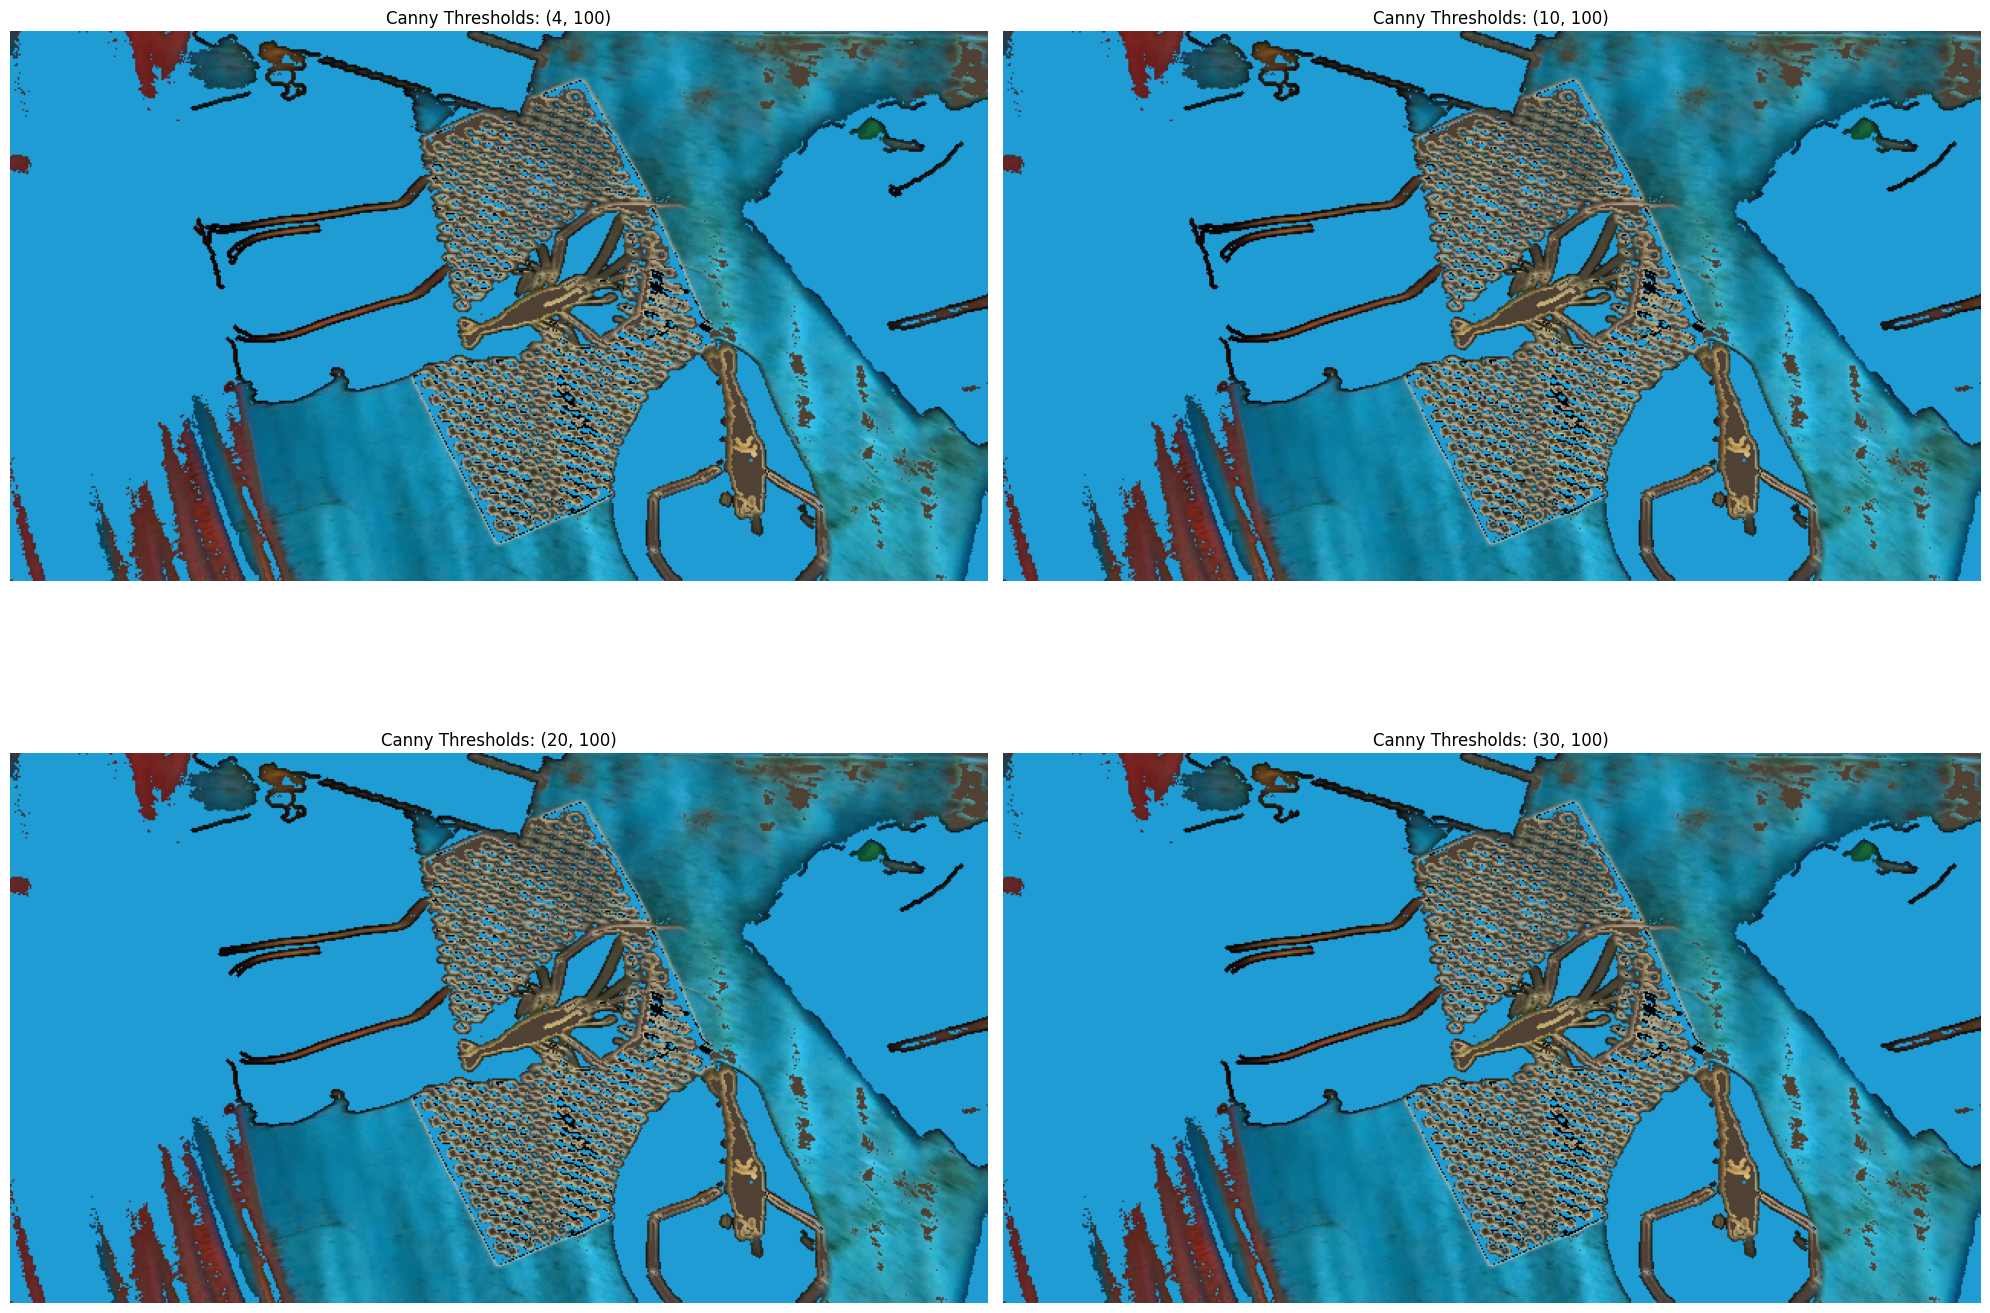

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Set the path for one test image
image_path = r"/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/measurement_paper_images/molt/all molt/undistorted/resized/undistorted_GX010191_8_309.jpg"

# Load the image
original_image = cv2.imread(image_path)
if original_image is None:
    print("Error: Could not load image!")
    exit()

# Define different threshold combinations to test
thresholds = [
    (4, 100),   # Very sensitive
    (10, 100),  # Moderately sensitive
    (20, 100),  # Less sensitive
    (30, 100)   # Original setting
]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

for idx, (low_threshold, high_threshold) in enumerate(thresholds):
    # Make a copy of the original image for this iteration
    image = original_image.copy()
    
    # ------------------------
    # Detect edges with current thresholds - THINNER EDGES
    # ------------------------
    gray_for_edge = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_for_edge = cv2.GaussianBlur(gray_for_edge, (3, 3), 0)
    edges = cv2.Canny(gray_for_edge, low_threshold, high_threshold)
    
    # Reduced kernel size and iterations for thinner edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))  # Smaller kernel
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)  # Fewer iterations
    
    non_edge_mask = cv2.bitwise_not(edges_dilated)

    # ------------------------
    # Color processing steps
    # ------------------------
    white_mask = cv2.inRange(image, (60, 60, 60), (255, 255, 255))
    very_white_mask = cv2.inRange(image, (150, 150, 150), (255, 255, 255))
    image[very_white_mask == 255] = [0, 0, 0]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, black_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    gray_color = np.array([52, 66, 79])
    bluish_color = [212, 156, 31]
    bluish_image = image.copy()
    bluish_image[:] = bluish_color

    # ------------------------
    # Apply recoloring
    # ------------------------
    white_non_edge = cv2.bitwise_and(white_mask, non_edge_mask)
    image[white_non_edge == 255] = gray_color

    black_non_edge = cv2.bitwise_and(black_mask, non_edge_mask)
    image[black_non_edge == 255] = bluish_image[black_non_edge == 255]

    # Display result in subplot
    axes[idx].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(f'Canny Thresholds: ({low_threshold}, {high_threshold})')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:

azure_color = [212, 156, 31]  # Azure in BGR (Blue, Green, Red)

# Define gray color and tolerance
gray_color = np.array([52, 66, 79])  # RGB value for gray
lower_bound = gray_color - 50
upper_bound = gray_color + 50

# Create a mask for the gray color
mask = cv2.inRange(image, lower_bound, upper_bound)

cv2.imwrite("mask.png", mask)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area and create a new mask for the contours
contours_mask = np.zeros_like(mask)  # A black mask of the same size as the original image

# Iterate through contours and draw only the ones with sufficient area
for contour in contours:
    area = cv2.contourArea(contour)
    if area >200:  
        
    
        # Filter by area
        # Draw the contours on the black mask
        cv2.drawContours(contours_mask, [contour], -1, 255, thickness=cv2.FILLED)  # Fill the contours in white

# Invert the contours mask (make contours black and the rest white)
contours_mask_inv = cv2.bitwise_not(contours_mask)

# Create a background image filled with the azure color
azure_background = np.full_like(image, azure_color, dtype=np.uint8)

# Mask out the contour areas and paint the rest azure
result = cv2.bitwise_and(image, image, mask=contours_mask)  # Keep the original image inside the contours
azure_areas = cv2.bitwise_and(azure_background, azure_background, mask=contours_mask_inv)  # Paint everything else azure

# Combine the original image (inside contours) with the azure background (outside contours)
final_result = cv2.add(result, azure_areas)

#Save the result
cv2.imwrite(os.path.join(output_path, os.path.basename(image_path)), final_result)

In [7]:
#save one of the images to this folder
# Save the processed image with thresholds (100, 200)
output_path = "processed_images/molt_processed.jpg"
os.makedirs("processed_images", exist_ok=True)
cv2.imwrite(output_path, image)
print(f"Saved processed image to: {output_path}")




Saved processed image to: processed_images/molt_processed.jpg


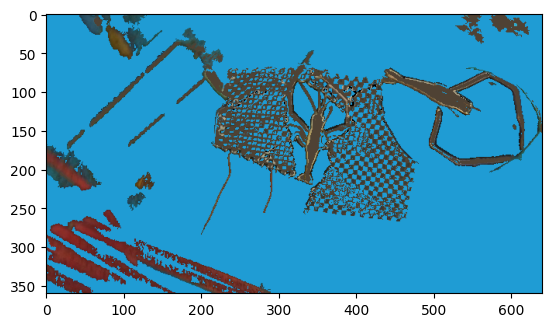

In [8]:
# Load and process image
image = cv2.imread(image_path)

# ------------------------
# Edge Detection - THINNER EDGES
# ------------------------
gray_for_edge = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_for_edge = cv2.GaussianBlur(gray_for_edge, (17, 17), 0)
edges = cv2.Canny(gray_for_edge, 10, 100)  # Using moderate threshold values

# Reduced kernel size and iterations for thinner edges
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
edges_dilated = cv2.dilate(edges, kernel, iterations=1)
non_edge_mask = cv2.bitwise_not(edges_dilated)

# ------------------------
# Initial Color Processing
# ------------------------
white_mask = cv2.inRange(image, (60, 60, 60), (255, 255, 255))
very_white_mask = cv2.inRange(image, (150, 150, 150), (255, 255, 255))
image[very_white_mask == 255] = [0, 0, 0]

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, black_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

gray_color = np.array([52, 66, 79])
azure_color = [212, 156, 31]  # Azure in BGR
bluish_image = image.copy()
bluish_image[:] = azure_color

# ------------------------
# Apply Initial Recoloring
# ------------------------
white_non_edge = cv2.bitwise_and(white_mask, non_edge_mask)
image[white_non_edge == 255] = gray_color

black_non_edge = cv2.bitwise_and(black_mask, non_edge_mask)
image[black_non_edge == 255] = bluish_image[black_non_edge == 255]

# ------------------------
# Azure Background Processing
# ------------------------
# Create mask for gray areas
lower_bound = gray_color - 50
upper_bound = gray_color + 50
gray_mask = cv2.inRange(image, lower_bound, upper_bound)

# Find and filter contours
contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_mask = np.zeros_like(gray_mask)

for contour in contours:
    area = cv2.contourArea(contour)
    if area > 200:
        cv2.drawContours(contours_mask, [contour], -1, 255, thickness=cv2.FILLED)

# Create and apply azure background
contours_mask_inv = cv2.bitwise_not(contours_mask)
azure_background = np.full_like(image, azure_color, dtype=np.uint8)

result = cv2.bitwise_and(image, image, mask=contours_mask)
azure_areas = cv2.bitwise_and(azure_background, azure_background, mask=contours_mask_inv)
final_result = cv2.add(result, azure_areas)

#import plt
import matplotlib.pyplot as plt
#plot the image
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
plt.show()


In [9]:
#save the image
cv2.imwrite("processed_images/molt_processed.jpg", final_result)

True

In [3]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Define input and output folders
input_folder = r"/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/measurement_paper_images/molt/all molt/undistorted/resized"
output_folder = r"/Users/gilbenor/Documents/code projects/msc/counting_research_algorithms/fifty_one/measurements/processed_images"
os.makedirs(output_folder, exist_ok=True)

# Pre-define constants
gray_color = np.array([52, 66, 79])
azure_color = [212, 156, 31]  # Azure in BGR
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

for image_file in tqdm(image_files):
    # Load image
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)
    
    # Edge Detection
    gray_for_edge = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_for_edge = cv2.GaussianBlur(gray_for_edge, (17, 17), 0)
    edges = cv2.Canny(gray_for_edge, 10, 100)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    non_edge_mask = cv2.bitwise_not(edges_dilated)

    # Color Processing
    white_mask = cv2.inRange(image, (60, 60, 60), (255, 255, 255))
    very_white_mask = cv2.inRange(image, (150, 150, 150), (255, 255, 255))
    image[very_white_mask == 255] = [0, 0, 0]

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, black_mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    bluish_image = np.full_like(image, azure_color)

    # Apply Recoloring
    white_non_edge = cv2.bitwise_and(white_mask, non_edge_mask)
    image[white_non_edge == 255] = gray_color

    black_non_edge = cv2.bitwise_and(black_mask, non_edge_mask)
    image[black_non_edge == 255] = bluish_image[black_non_edge == 255]

    # Azure Background Processing
    gray_mask = cv2.inRange(image, gray_color - 50, gray_color + 50)
    contours, _ = cv2.findContours(gray_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_mask = np.zeros_like(gray_mask)

    for contour in contours:
        if cv2.contourArea(contour) > 200:
            cv2.drawContours(contours_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Final Composition
    contours_mask_inv = cv2.bitwise_not(contours_mask)
    azure_background = np.full_like(image, azure_color, dtype=np.uint8)
    result = cv2.bitwise_and(image, image, mask=contours_mask)
    azure_areas = cv2.bitwise_and(azure_background, azure_background, mask=contours_mask_inv)
    final_result = cv2.add(result, azure_areas)

    # Save result
    cv2.imwrite(os.path.join(output_folder, image_file), final_result)

100%|██████████| 191/191 [04:25<00:00,  1.39s/it]


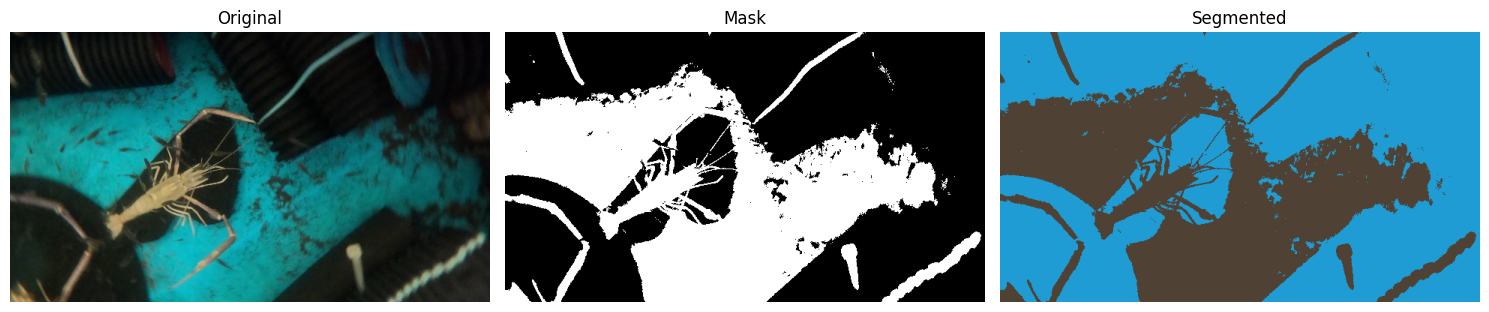

Saved segmented image to test_segmented.jpg


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt# Test on a single image
input_image = "/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/measurement_paper_images/molt/all molt/undistorted/resized/undistorted_GX010194_26_373.jpg"  # Replace with your test image path
output_image = "test_segmented.jpg"

# Read and process the image
img = cv2.imread(input_image)
if img is not None:
    # Define colors (BGR format)
    TURQUOISE_COLOR = np.array([31, 156, 212])  # Brownish color for exuviae
    AZURE_COLOR = np.array([79, 66, 52])  # Turquoise for background

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Simple threshold for dark areas (black backgrounds)
    _, mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)  # Note: Removed _INV
    
    # Create the segmented image
    segmented = np.zeros_like(img)
    
    # Apply colors directly - everything turquoise except dark areas
    segmented[mask > 0] = AZURE_COLOR  # Light areas get turquoise
    segmented[mask == 0] = TURQUOISE_COLOR     # Dark areas get azure
    
    # Create figure with subplots
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    
    # Mask
    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')
    
    # Segmented result
    plt.subplot(133)
    plt.imshow(segmented)
    plt.title('Segmented')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Save the result
    cv2.imwrite(output_image, segmented)
    print(f"Saved segmented image to {output_image}")
else:
    print("Could not read the image")

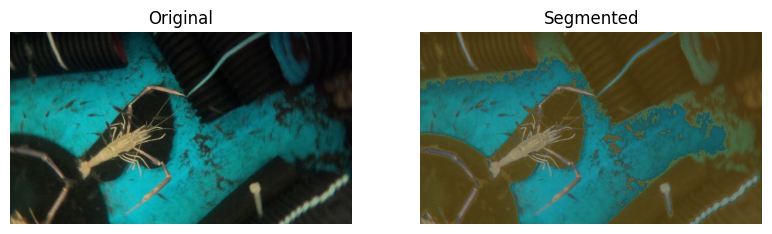

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature as feature

# Test on a single image
input_image = "/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/measurement_paper_images/molt/all molt/undistorted/resized/undistorted_GX010194_26_373.jpg"  # Replace with your test image path
output_image = "test_segmented.jpg"

# Read and process the image
img = cv2.imread(input_image)


def create_gabor_filters():
    filters = []
    ksize = 21
    for theta in range(0, 180, 45):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def apply_gabor_filters(img, filters):
    newimg = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(newimg, fimg, newimg)
    return newimg

def segment_with_texture_preserve(image):
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Get basic segmentation mask
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Instead of solid colors, blend with original image
    segmented = np.zeros_like(image)
    
    # For light areas (mask > 0), tint towards azure
    azure_tint = np.full_like(image, AZURE_COLOR)
    light_blend = cv2.addWeighted(image, 0.7, azure_tint, 0.3, 0)
    
    # For dark areas (mask == 0), tint towards turquoise
    turquoise_tint = np.full_like(image, TURQUOISE_COLOR)
    dark_blend = cv2.addWeighted(image, 0.7, turquoise_tint, 0.3, 0)
    
    # Combine based on mask
    segmented[mask > 0] = light_blend[mask > 0]
    segmented[mask == 0] = dark_blend[mask == 0]
    
    return segmented
#color based segmentation
if img is not None:
    segmented = segment_with_texture_preserve(img)
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    plt.title('Segmented')
    plt.axis('off')
    





(-0.5, 639.5, 359.5, -0.5)

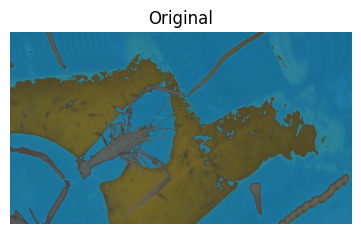

In [8]:
def color_based_segmentation(image, lower_bound=None, upper_bound=None):
    """
    Segments the image based on color while preserving texture.
    
    Args:
        image: Input BGR image
        lower_bound: Lower HSV bound for segmentation (optional)
        upper_bound: Upper HSV bound for segmentation (optional)
    Returns:
        Segmented image with preserved texture
    # """
    # # Default color bounds for general purpose segmentation
    # if lower_bound is None:
    #     lower_bound = np.array([0, 30, 30])
    # if upper_bound is None:
    #     upper_bound = np.array([180, 255, 255])
    
    # # Convert to HSV for better color segmentation
    # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # # Create mask
    # mask = cv2.inRange(hsv, lower_bound, upper_bound)
    
    # Define colors (BGR format)
    TURQUOISE_COLOR = np.array([31, 156, 212])  # Turquoise for background
    AZURE_COLOR = np.array([79, 66, 52])        # Azure for exuviae
    
    # Create the segmented image
    segmented = np.zeros_like(image)
    
    # Apply colors directly - everything turquoise except dark areas
    segmented[mask > 0] = AZURE_COLOR  # Light areas get azure
    segmented[mask == 0] = TURQUOISE_COLOR  # Dark areas get turquoise
    
    # Blend with original to preserve texture details
    alpha = 0.7  # Blend factor
    return cv2.addWeighted(segmented, alpha, image, 1-alpha, 0)

import cv2
import numpy as np
import matplotlib.pyplot as plt# Test on a single image
input_image = "/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/measurement_paper_images/molt/all molt/undistorted/resized/undistorted_GX010194_26_373.jpg"  # Replace with your test image path
output_image = "test_segmented.jpg"

# Read and process the image
img = cv2.imread(input_image)

img=color_based_segmentation(img)
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow((img))
plt.title('Original')
plt.axis('off')
